<b><font color="SteelBlue" size="+3">Classifiez automatiquement des biens de consommation</font></b>

# Introduction

## Contexte

Nous sommes au cœur d'un projet innovant chez "Place de marché", une entreprise qui s'apprête à lancer une marketplace e-commerce dynamique et multilingue. Dans cet univers, les vendeurs ont l'opportunité de présenter leurs articles aux acheteurs potentiels en partageant des photos et des descriptions des produits. Actuellement, la classification des articles en catégories est un processus manuel et sujet à erreurs, ce qui présente des défis en termes de fiabilité et d'efficacité. Avec un volume d'articles qui augmente, il devient primordial d'automatiser cette classification pour améliorer l'expérience utilisateur tant pour les vendeurs, en simplifiant le processus de mise en ligne, que pour les acheteurs, en rendant la recherche de produits plus intuitive.

## Objectifs

L'objectif principal est de développer un moteur de classification automatique qui utilisera à la fois le texte et l'image pour catégoriser efficacement les produits. Ce moteur devra être capable d'analyser les descriptions textuelles et visuelles pour regrouper les articles dans les catégories adéquates. Pour y parvenir, il est essentiel de mettre en œuvre des méthodes avancées de traitement du langage naturel (NLP) ainsi que des techniques de vision par ordinateur pour extraire des caractéristiques pertinentes des données. L'étape finale consistera à projeter ces caractéristiques dans un espace à deux dimensions, facilitant ainsi l'analyse et la segmentation en clusters. Ce projet vise à valider la faisabilité de cette approche de classification, qui est cruciale pour le passage à l'échelle de la marketplace.

## Imports

In [147]:
# Chargement des librairies
# Builtin
import os

# Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from wordcloud import WordCloud

# NLP
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
import torch
import tensorflow as tf
import tensorflow_hub as hub
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from sklearn.decomposition import NMF

# Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ML
from sklearn.cluster import KMeans

# perso
from Deveau_Estelle_2_NLP_func_042024 import *

In [148]:
print(torch.version.cuda)
print(torch.backends.cudnn.version())

12.1
8801


In [149]:
print(torch.cuda.is_available())  # Affiche True si CUDA est disponible
print(torch.cuda.device_count())  # Affiche le nombre de GPU disponibles
print(torch.cuda.get_device_name(0))  # Affiche le nom du GPU

True
1
NVIDIA GeForce RTX 3060


In [150]:
print(torch.__version__)
print(torch.cuda.is_available())

2.2.2
True


## Data

In [151]:
os.listdir()

['.ipynb_checkpoints',
 'champagne_products.csv',
 'data',
 'Deveau_Estelle_1_notebook_txt_faisabilite_042024.ipynb',
 'Deveau_Estelle_2_NLP_func_042024.py',
 'Deveau_Estelle_3_notebook_img_faisabilite_042024.ipynb',
 'Deveau_Estelle_4_IMG_func_042024.py',
 'Deveau_Estelle_5_notebook_img_classification_042024.ipynb',
 'Deveau_Estelle_6_notebook_API_042024.ipynb',
 'exemple.jpg',
 'model_augmented_best.weights.h5',
 'model_augmented_data_best.weights.h5',
 'model_augmented_data_best_with_generator.weights.h5',
 'model_augmented_data_best_with_seq.weights.h5',
 'model_best.keras',
 'model_best.weights.h5',
 'model_densenet201_best.weights.h5',
 'model_inceptionresnetv2_best.weights.h5',
 'model_iresnetv2_ad_best.weights.h5',
 'model_vgg16_best.weights.h5',
 'OC_projet6.pptx',
 'pythonProject',
 'svg',
 'Weather_Images_CNN_Transfer_Learning_Stage_1_feasibility_V1.0.ipynb',
 'Weather_Images_CNN_Transfer_Learning_Stage_2_supervised_classification_V1.0.ipynb',
 '__pycache__',
 '~$OC_projet6.

In [152]:
os.listdir("data/sources/")

['Dataset+projet+prétraitement+textes+images.zip',
 'flipkart_com-ecommerce_sample_1050.csv',
 'generatedimages',
 'generatedimages - Copie',
 'Images']

In [153]:
path     = "./data/sources/"
filename = "flipkart_com-ecommerce_sample_1050.csv"

In [154]:
data = pd.read_csv(path + filename)

In [155]:
# Modification des affichages de colonnes, lignes et largeurs de colonnes pour avoir un maximum d'information
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', None)

# Exploration des données

## Quick tour

In [156]:
data.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [157]:
data.shape

(1050, 15)

In [158]:
data.dtypes.value_counts()

object     12
float64     2
bool        1
Name: count, dtype: int64

In [159]:
data.describe()

retail_price  discounted_price
count    1049.000000       1049.000000
mean     2186.197331       1584.527169
std      7639.229411       7475.099680
min        35.000000         35.000000
25%       555.000000        340.000000
50%       999.000000        600.000000
75%      1999.000000       1199.000000
max    201000.000000     201000.000000

In [160]:
data.nunique()

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

In [161]:
# Valeurs manquantes
missing_values_count = data.isnull().sum()
total_cells = np.product(data.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print('Le pourcentage de valeurs manquantes est de', round(percent_missing, 2),'%')

Le pourcentage de valeurs manquantes est de 2.17 %


In [162]:
percent_missing_values =  round((missing_values_count / len(data)) * 100, 2)
missing_data = pd.concat([missing_values_count, percent_missing_values], axis=1, keys=['Nombre de valeurs manquantes', 'Pourcentage de valeurs manquantes'])
display(missing_data)

Nombre de valeurs manquantes  \
uniq_id                                             0   
crawl_timestamp                                     0   
product_url                                         0   
product_name                                        0   
product_category_tree                               0   
pid                                                 0   
retail_price                                        1   
discounted_price                                    1   
image                                               0   
is_FK_Advantage_product                             0   
description                                         0   
product_rating                                      0   
overall_rating                                      0   
brand                                             338   
product_specifications                              1   

                         Pourcentage de valeurs manquantes  
uniq_id                                               0.00  
crawl_timestamp                                       0.00  
product_url                                           0.00  
product_name                                          0.00  
product_category_tree                                 0.00  
pid                                                   0.00  
retail_price                                          0.10  
discounted_price                                      0.10  
image                                                 0.00  
is_FK_Advantage_product                               0.00  
description                                           0.00  
product_rating                                        0.00  
overall_rating                                        0.00  
brand                                                32.19  
product_specifications                                0.10

<Axes: title={'center': 'Valeurs présentes dans notre jeu de données'}>

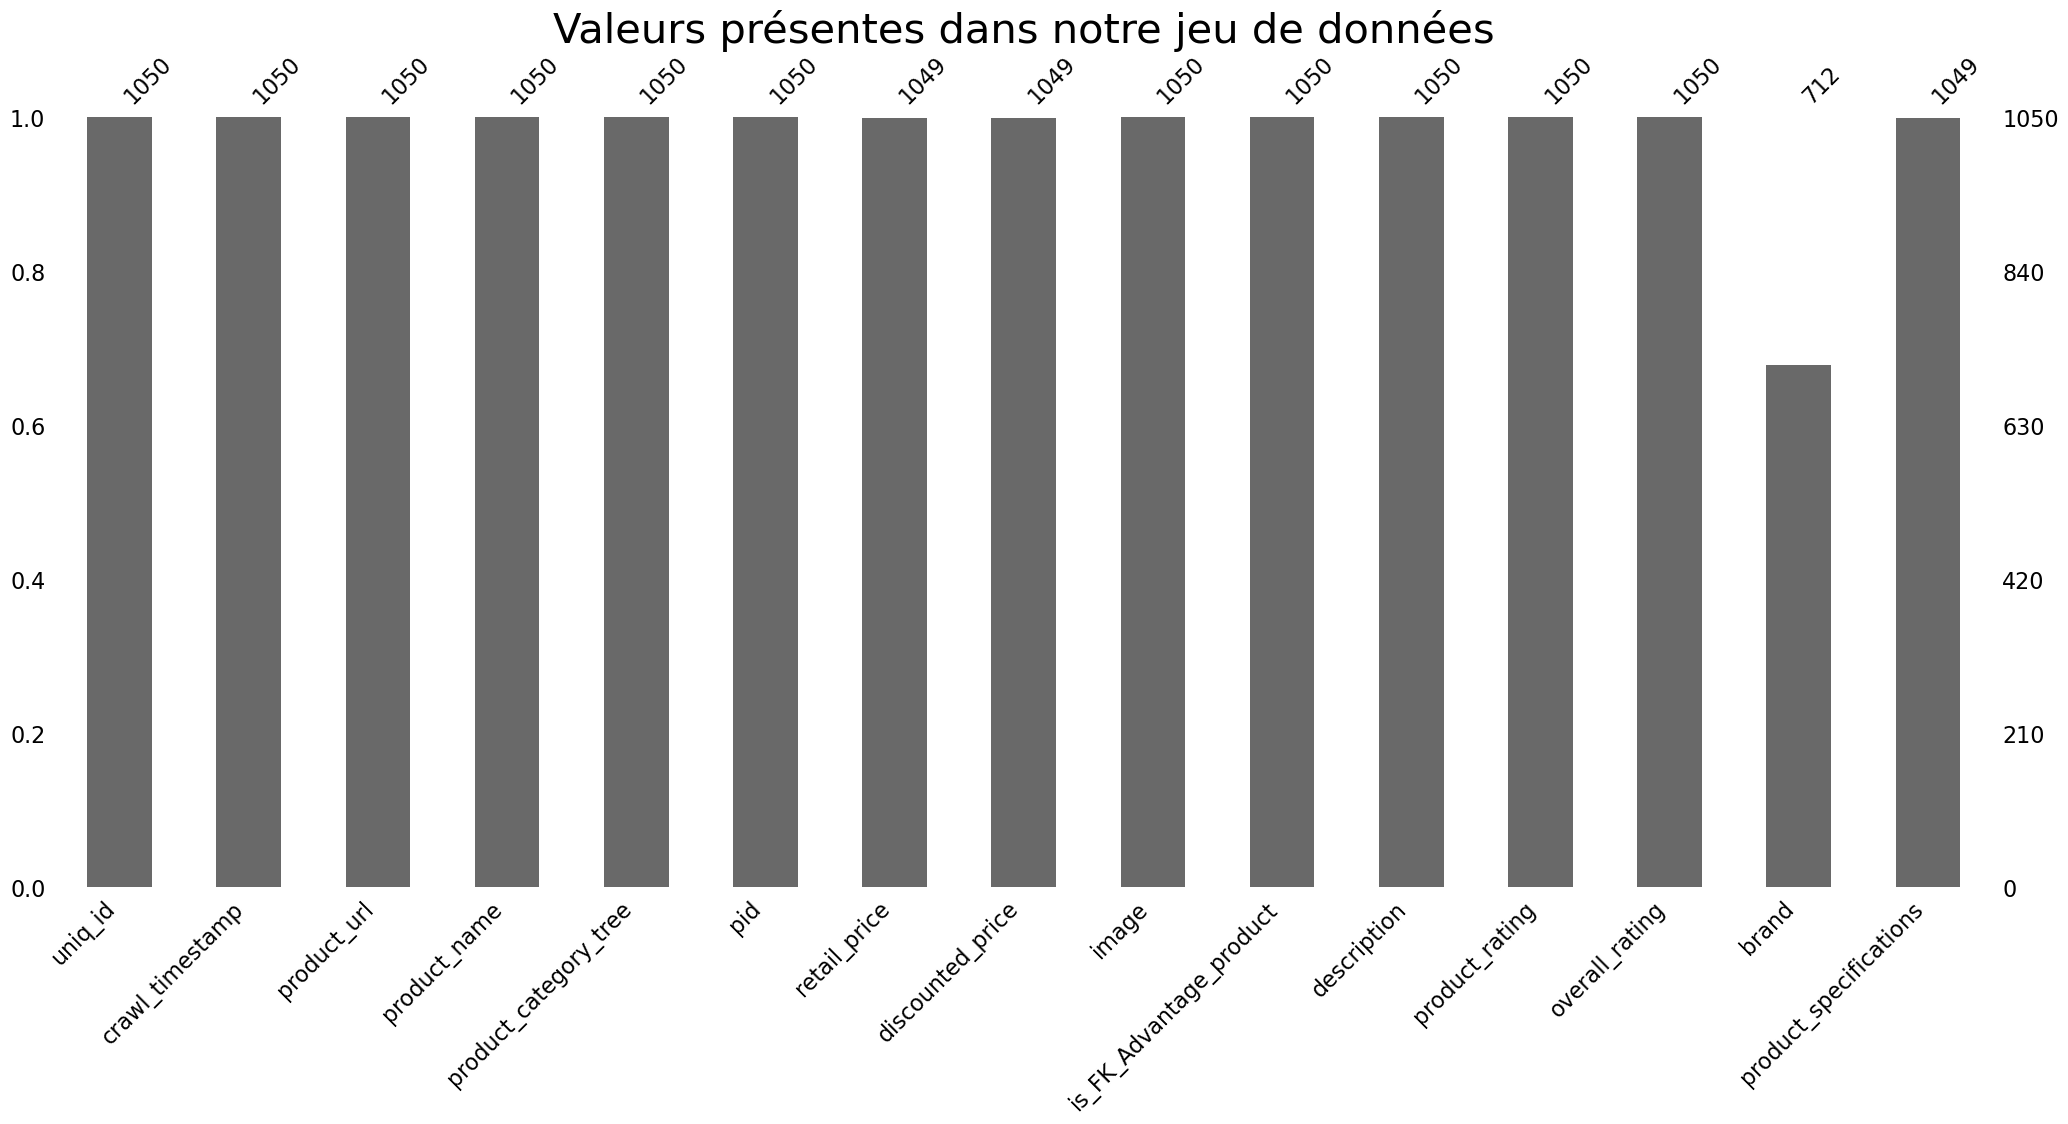

In [163]:
plt.title("Valeurs présentes dans notre jeu de données", fontsize=30)
msno.bar(data)

<Axes: >

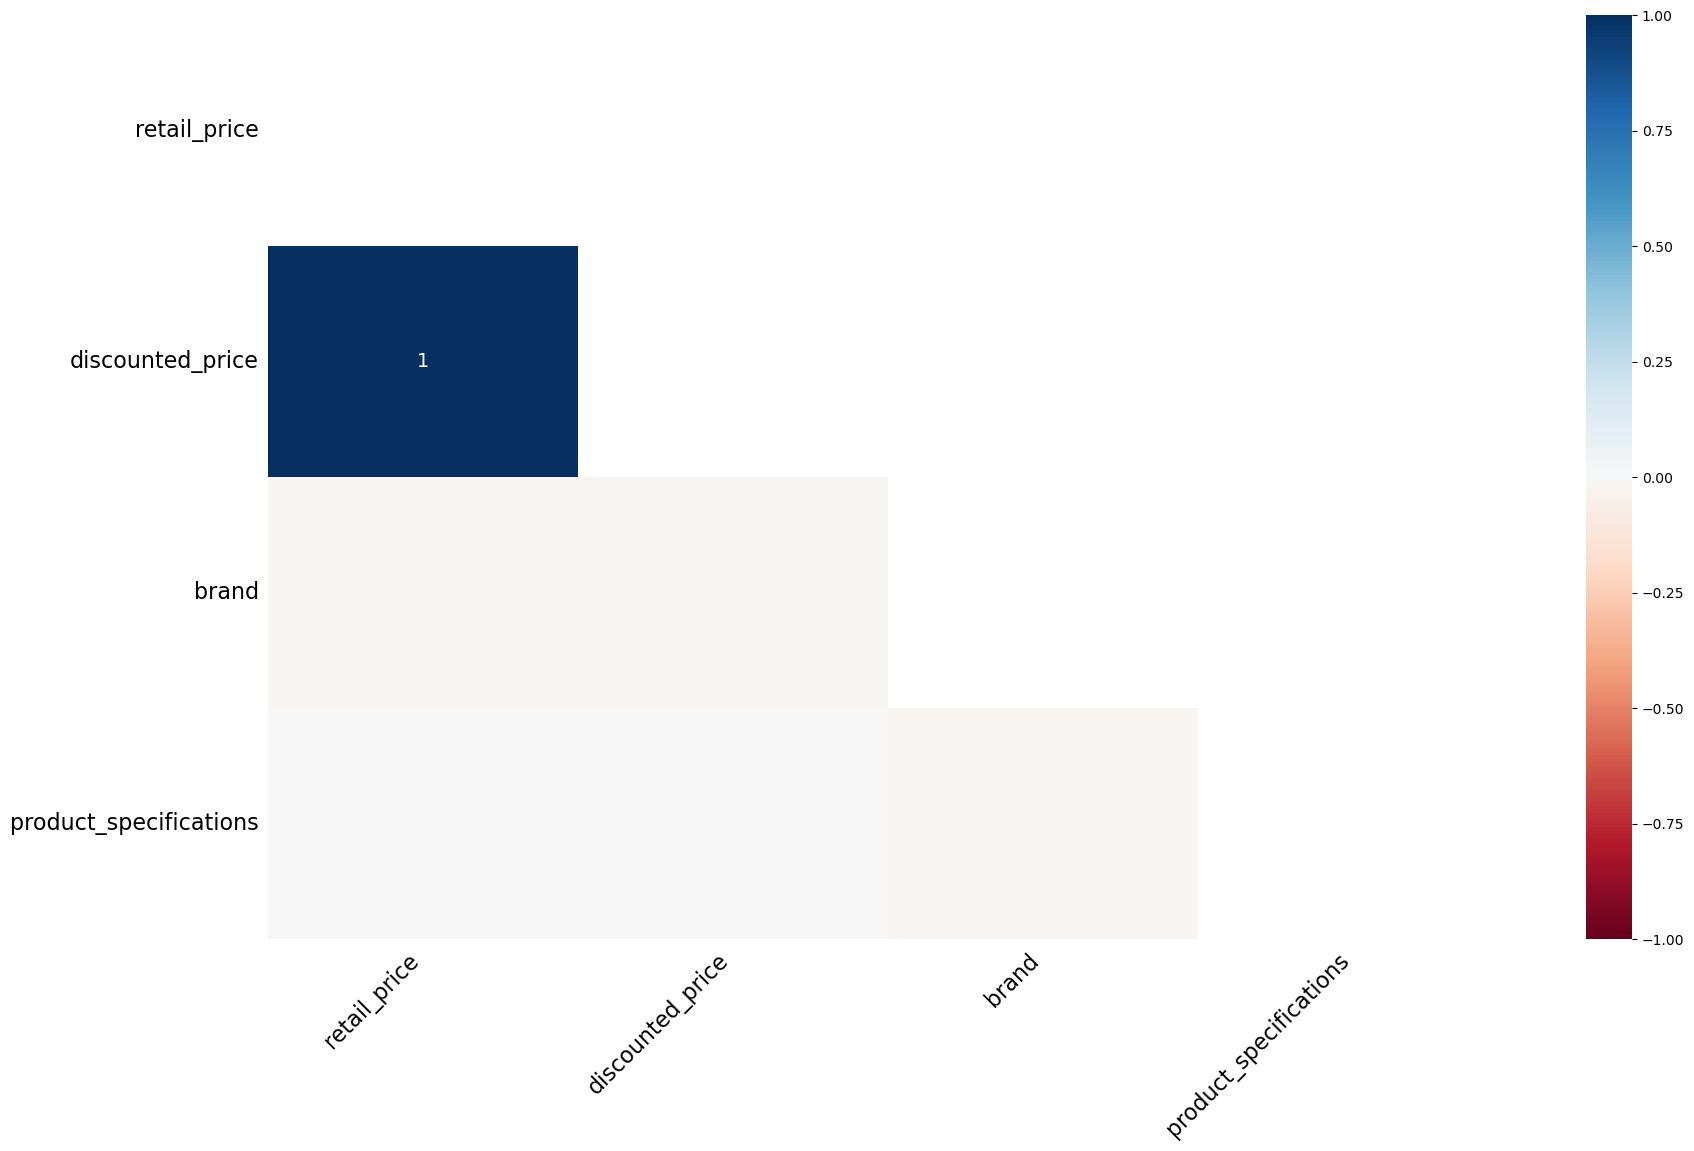

In [164]:
msno.heatmap(data)

## Compréhension des Variables

In [165]:
data.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

<b>uniq_id</b> : Un identifiant unique pour chaque entrée de produit.<br>
<b>crawl_timestamp</b> : La date et l'heure de la collecte des données pour chaque produit.<br>
<b>product_url</b> : L'URL directe du produit sur le site de Flipkart.<br>
<b>product_name</b> : Le nom du produit.<br>
<b>product_category_tree</b> : Une chaîne de caractères représentant la catégorie et les sous-catégories du produit dans l'arborescence des catégories de Flipkart.<br>
<b>pid</b> : Un identifiant de produit spécifique à Flipkart.<br>
<b>retail_price</b> : Le prix de vente conseillé du produit.<br>
<b>discounted_price</b> : Le prix remisé du produit.<br>
<b>image</b> : Le nom de fichier de l'image du produit semble être uniq_id.jpg.<br>
<b>is_FK_Advantage_product</b> : Un booléen indiquant si le produit est vendu sous le programme Flipkart Advantage.<br>
<b>description</b> : Une brève description du produit.<br>
<b>product_rating</b> : La note du produit donnée par les utilisateurs<br>
<b>overall_rating</b> : Semblable à product_rating<br>
<b>brand</b> : La marque du produit.<br>
<b>product_specifications</b> : Un champ structuré contenant des spécifications détaillées du produit, telles que la matière, la marque, etc., probablement sous forme d'un dictionnaire ou d'un objet JSON.<br>

In [166]:
# Vérification de la correspondance entre 'image' et 'uniq_id' + '.jpg'
data['check'] = data['image'] == (data['uniq_id'] + '.jpg')

# Vérifier si toutes les lignes respectent cette condition
all_match = data['check'].all()

print(f"Toutes les entrées dans 'image' correspondent à 'uniq_id.jpg' : {all_match}")


Toutes les entrées dans 'image' correspondent à 'uniq_id.jpg' : True


In [167]:
# Liste de toutes les colonnes à conserver
cols_to_keep = ['uniq_id', 'product_category_tree', 'description']

# Pré-traitements des Données

In [168]:
df = data[cols_to_keep]

In [169]:
df.head(5)

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   
3  d4684dcdc759dd9cdf41504698d737d8   
4  6325b6870c54cd47be6ebfbffa620ec7   

                               product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >>...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   

                                         description  
0  Key Features of Elegance Polyester Multicolor ...  
1  Specifications of Sathiyas Cotton Bath Towel (...  
2  Key Features of Eurospa Cotton Terry Face Towe...  
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  
4  Key Features of Jaipur Print Cotton Floral Kin...

In [170]:
df.nunique()

uniq_id                  1050
product_category_tree     642
description              1050
dtype: int64

## Récupération des catégories

In [171]:
# Transformation de 'product_category_tree' en 'product_category'
df = df.copy()
df['product_category'] = df['product_category_tree'].apply(lambda x: x.split('>>')[0].strip('[" '))
df = df[['uniq_id', 'product_category', 'description']]

df.head(5)

uniq_id product_category  \
0  55b85ea15a1536d46b7190ad6fff8ce7  Home Furnishing   
1  7b72c92c2f6c40268628ec5f14c6d590        Baby Care   
2  64d5d4a258243731dc7bbb1eef49ad74        Baby Care   
3  d4684dcdc759dd9cdf41504698d737d8  Home Furnishing   
4  6325b6870c54cd47be6ebfbffa620ec7  Home Furnishing   

                                         description  
0  Key Features of Elegance Polyester Multicolor ...  
1  Specifications of Sathiyas Cotton Bath Towel (...  
2  Key Features of Eurospa Cotton Terry Face Towe...  
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  
4  Key Features of Jaipur Print Cotton Floral Kin...

In [172]:
# Valeurs manquantes
missing_values_count = df.isnull().sum()
total_cells = np.product(data.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print('Le pourcentage de valeurs manquantes est de', round(percent_missing, 2),'%')

Le pourcentage de valeurs manquantes est de 0.0 %


In [173]:
print("Valeurs uniques pour product_category dans df:", df['product_category'].unique())

Valeurs uniques pour product_category dans df: ['Home Furnishing' 'Baby Care' 'Watches' 'Home Decor & Festive Needs'
 'Kitchen & Dining' 'Beauty and Personal Care' 'Computers']


In [174]:
df.product_category.value_counts()

product_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

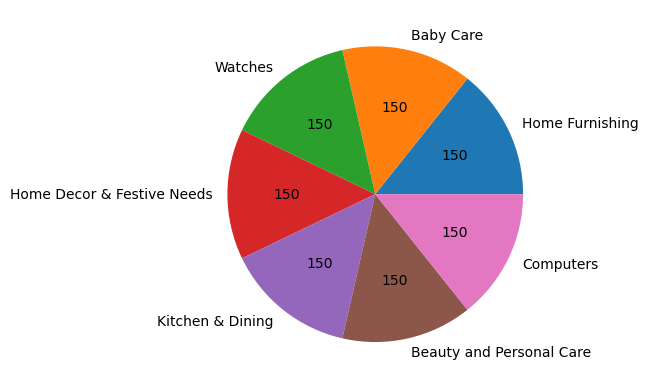

In [175]:
# Compter les valeurs de chaque catégorie
counts = df.product_category.value_counts()

# Afficher le graphique en secteurs
counts.plot(kind="pie", autopct=lambda p: '{:.0f}'.format(p * sum(counts) / 100))
plt.ylabel("") 
plt.show()

In [176]:
# sauvegarde des données
path = "data/cleaned/"
filename = "data.csv"
df.to_csv(path+filename, index=False)

## Taille des descriptions

In [177]:
lengths = df.description.apply(lambda i : len(i))

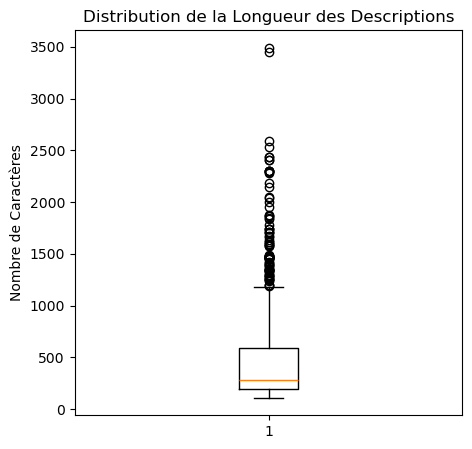

In [178]:
# Création d'un boxplot
plt.figure(figsize=(5, 5))
plt.boxplot(lengths)
plt.title('Distribution de la Longueur des Descriptions')
plt.ylabel('Nombre de Caractères')
plt.show()

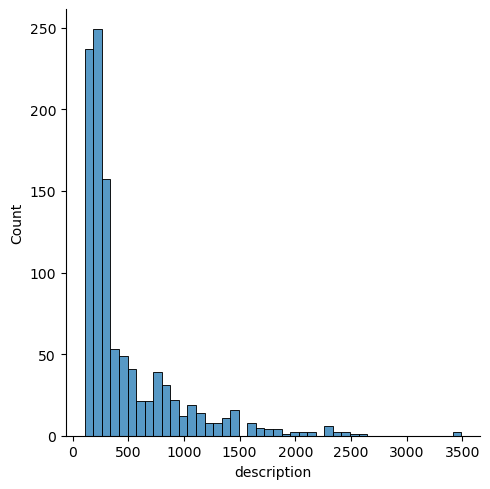

In [179]:
sns.displot(lengths)

In [180]:
df["_len_txt"] = lengths

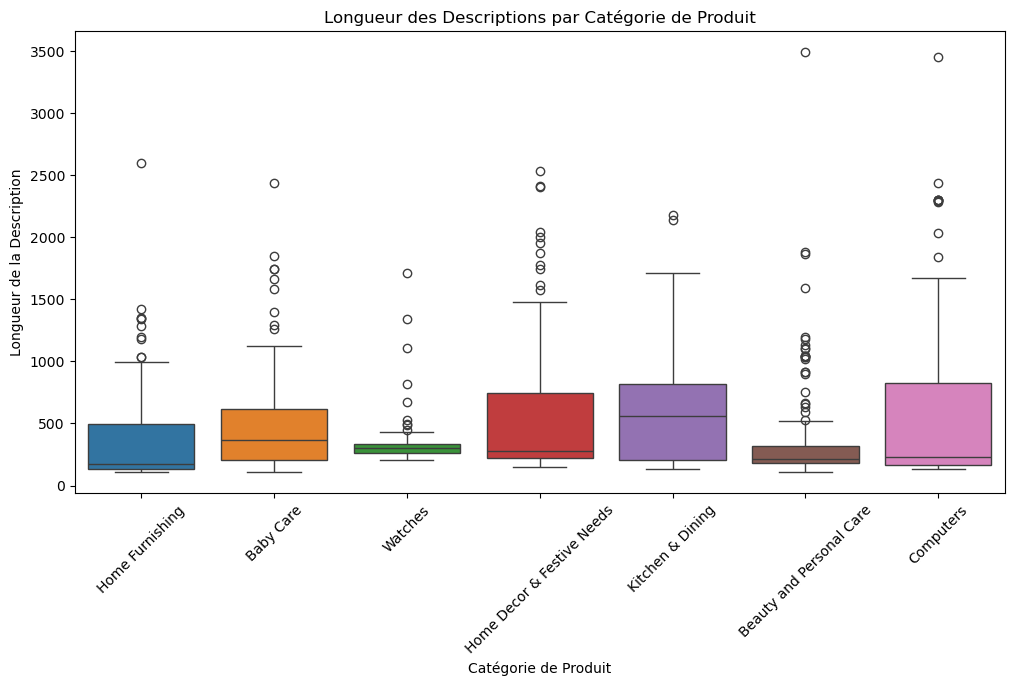

In [181]:
# Boxplot groupé
plt.figure(figsize=(12, 6))
sns.boxplot(x='product_category', y='_len_txt', data=df, palette='tab10', hue='product_category')
plt.xticks(rotation=45)  # Cela aide si les noms des catégories sont longs ou nombreux
plt.title('Longueur des Descriptions par Catégorie de Produit')
plt.xlabel('Catégorie de Produit')
plt.ylabel('Longueur de la Description')
plt.show()

## Doublons

In [182]:
df.duplicated().sum()

0

In [183]:
df.duplicated(subset='description').sum()

0

## Sur un document

In [192]:
doc = df.description.sample(1)
doc = doc.values[0]
doc

'Buy Lapguard HP Pavilion dv5-1014tx 6 Cell Laptop Battery only for Rs. 0.0 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!'

### Nettoyage des descriptions

In [193]:
cleaned_text = process_text(doc, clean=True)
print(cleaned_text)

buy lapguard hp pavilion dvtx  cell laptop battery only for rs  from flipkartcom only genuine products  day replacement guarantee free shipping cash on delivery


### Tokenisation

Test de différent tokenizer

In [194]:
def display_tokens_info(tokens):
    print(f"nb tokens {len(tokens)}, nb tokens uniques {len(set(tokens))}")
    print(tokens[:30])

#### Word_tokenize

In [195]:
tokens = process_text(doc, clean=True, tokenize_method='word_tokenize')
display_tokens_info(tokens)

nb tokens 24, nb tokens uniques 23
['buy', 'lapguard', 'hp', 'pavilion', 'dvtx', 'cell', 'laptop', 'battery', 'only', 'for', 'rs', 'from', 'flipkartcom', 'only', 'genuine', 'products', 'day', 'replacement', 'guarantee', 'free', 'shipping', 'cash', 'on', 'delivery']


#### Wordpunct_tokenize

In [196]:
tokens = process_text(doc, clean=True, tokenize_method='wordpunct')
display_tokens_info(tokens)

nb tokens 24, nb tokens uniques 23
['buy', 'lapguard', 'hp', 'pavilion', 'dvtx', 'cell', 'laptop', 'battery', 'only', 'for', 'rs', 'from', 'flipkartcom', 'only', 'genuine', 'products', 'day', 'replacement', 'guarantee', 'free', 'shipping', 'cash', 'on', 'delivery']


#### Regex Tokenize

In [197]:
tokens = process_text(doc, clean=True, tokenize_method='regex')
display_tokens_info(tokens)

nb tokens 24, nb tokens uniques 23
['buy', 'lapguard', 'hp', 'pavilion', 'dvtx', 'cell', 'laptop', 'battery', 'only', 'for', 'rs', 'from', 'flipkartcom', 'only', 'genuine', 'products', 'day', 'replacement', 'guarantee', 'free', 'shipping', 'cash', 'on', 'delivery']


=> Résultats équivalents

### Suppression des Stop words

In [198]:
cleaned_text = process_text(doc, clean=True, tokenize_method='word_tokenize', remove_stopwords=True)
print(cleaned_text)

['buy', 'lapguard', 'hp', 'pavilion', 'dvtx', 'cell', 'laptop', 'battery', 'rs', 'flipkartcom', 'genuine', 'products', 'day', 'replacement', 'guarantee', 'free', 'shipping', 'cash', 'delivery']


### Stemming

In [199]:
cleaned_text = process_text(doc, clean=True, tokenize_method='word_tokenize', remove_stopwords=True, stemming=True, lemmatization=False)
print(cleaned_text)

['buy', 'lapguard', 'hp', 'pavilion', 'dvtx', 'cell', 'laptop', 'batteri', 'rs', 'flipkartcom', 'genuin', 'product', 'day', 'replac', 'guarante', 'free', 'ship', 'cash', 'deliveri']


### Lemmatization

In [200]:
cleaned_text = process_text(doc, clean=True, tokenize_method='word_tokenize', remove_stopwords=True, stemming=False, lemmatization=True)
print(cleaned_text)

['buy', 'lapguard', 'hp', 'pavilion', 'dvtx', 'cell', 'laptop', 'battery', 'r', 'flipkartcom', 'genuine', 'product', 'day', 'replacement', 'guarantee', 'free', 'shipping', 'cash', 'delivery']


=> A première vue, la lemmatization favorisera une meilleure distinction sémantique entre les catégories.

## Sur le corpus

### Suppression des mots uniques

In [47]:
# Aplatir la liste de listes en une seule liste de tokens
all_tokens = [token for sublist in df['description'] for token in sublist]

corpus = "".join(all_tokens)

In [48]:
corpus[:1000]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

In [49]:
len(corpus)

497512

In [50]:
processed_corpus = process_text(corpus, clean=True, tokenize_method='word_tokenize',
                                    remove_stopwords=True, stemming=False,
                                    lemmatization=True)
display_tokens_info(processed_corpus)

nb tokens 54277, nb tokens uniques 5513
['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtainelegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'cm', 'height', 'pack', 'price', 'r', 'curtain', 'enhances', 'look', 'interiorsthis', 'curtain', 'made', 'high', 'quality']


In [51]:
# Calculer la distribution de fréquence des tokens
freq_dist = FreqDist(processed_corpus)

In [52]:
# Liste des mots avec une fréquence de 1
hapaxes = freq_dist.hapaxes()

# Affichage de la liste des hapaxes
print(hapaxes[:20])

['curtainelegance', 'interiorsthis', 'fabricit', 'ringit', 'romantic', 'lovingthis', 'wrinkle', 'apparancegive', 'modernistic', 'surreal', 'steal', 'valance', 'close', 'joyous', 'softly', 'filter', 'sunlightspecifications', 'duster', 'asvtwl', 'mediam']


In [53]:
# Appel de la fonction 'process_text' avec la suppression des mots avec une frequence de 1
processed_corpus = process_text(corpus, clean=True, tokenize_method='word_tokenize', 
                              remove_stopwords=True, stemming=False, 
                              lemmatization=True, words_to_remove=hapaxes)

display_tokens_info(processed_corpus)

nb tokens 52220, nb tokens uniques 3456
['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'cm', 'height', 'pack', 'price', 'r', 'curtain', 'enhances', 'look', 'curtain', 'made', 'high', 'quality', 'polyester', 'feature']


# Exploratory Data Analysis

## Global

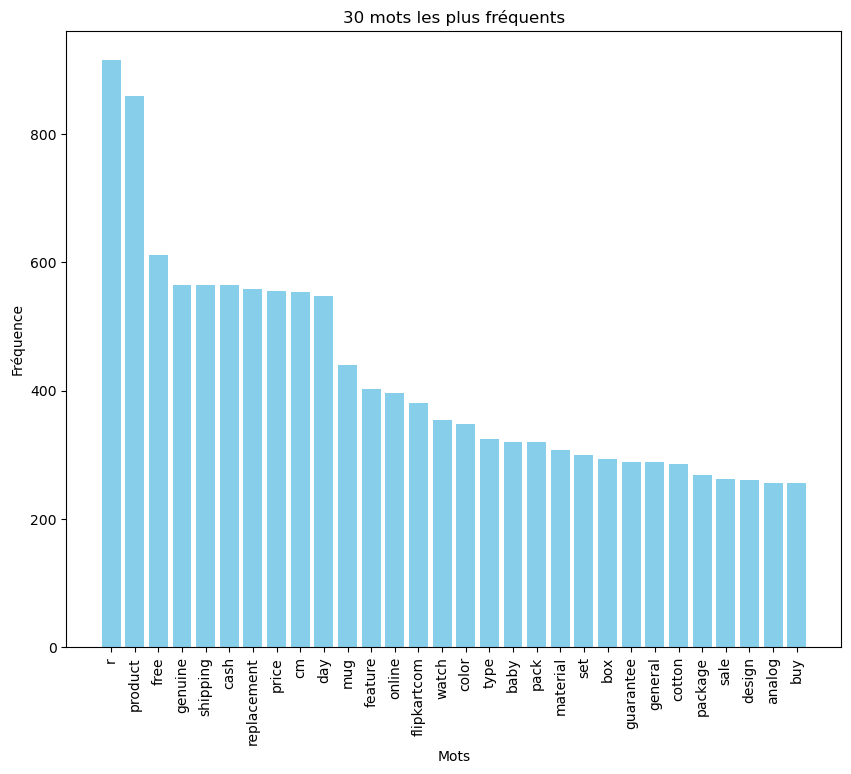

In [54]:
# Calculer la distribution de fréquence des tokens
freq_dist = FreqDist(processed_corpus)

# 30 mots les plus fréquents
common_words = freq_dist.most_common(30)

# Séparation des mots et de leurs fréquences
words, frequencies = zip(*common_words)

# Création du graphique
plt.figure(figsize=(10, 8))
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Mots')
plt.ylabel('Fréquence')
plt.xticks(rotation=90)
plt.title('30 mots les plus fréquents')
plt.show()

In [55]:
common_words

[('r', 915),
 ('product', 860),
 ('free', 611),
 ('genuine', 564),
 ('shipping', 564),
 ('cash', 564),
 ('replacement', 559),
 ('price', 555),
 ('cm', 554),
 ('day', 547),
 ('mug', 440),
 ('feature', 403),
 ('online', 396),
 ('flipkartcom', 380),
 ('watch', 354),
 ('color', 347),
 ('type', 324),
 ('baby', 320),
 ('pack', 319),
 ('material', 307),
 ('set', 300),
 ('box', 293),
 ('guarantee', 289),
 ('general', 288),
 ('cotton', 285),
 ('package', 268),
 ('sale', 262),
 ('design', 260),
 ('analog', 255),
 ('buy', 255)]

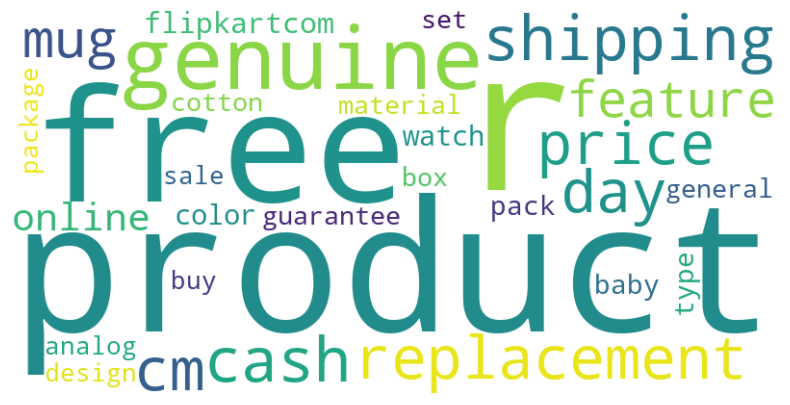

In [56]:
# Création d'un nuage de mots
common_words_dict = dict(common_words)

# Création d'un nuage de mots à partir des fréquences
wordcloud = WordCloud(width=800, height=400, background_color='white', min_font_size=10).generate_from_frequencies(common_words_dict)

# Affichage du nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Par catégories

Pour la catégorie Baby Care
nb tokens 8194, nb tokens uniques 1066
['specification', 'sathiyas', 'cotton', 'bath', 'towel', 'bath', 'towel', 'red', 'yellow', 'blue', 'bath', 'towel', 'feature', 'machine', 'washable', 'yes', 'material', 'cotton', 'design', 'self', 'design', 'general', 'brand', 'sathiyas', 'type', 'bath', 'towel', 'gsm', 'model', 'name']


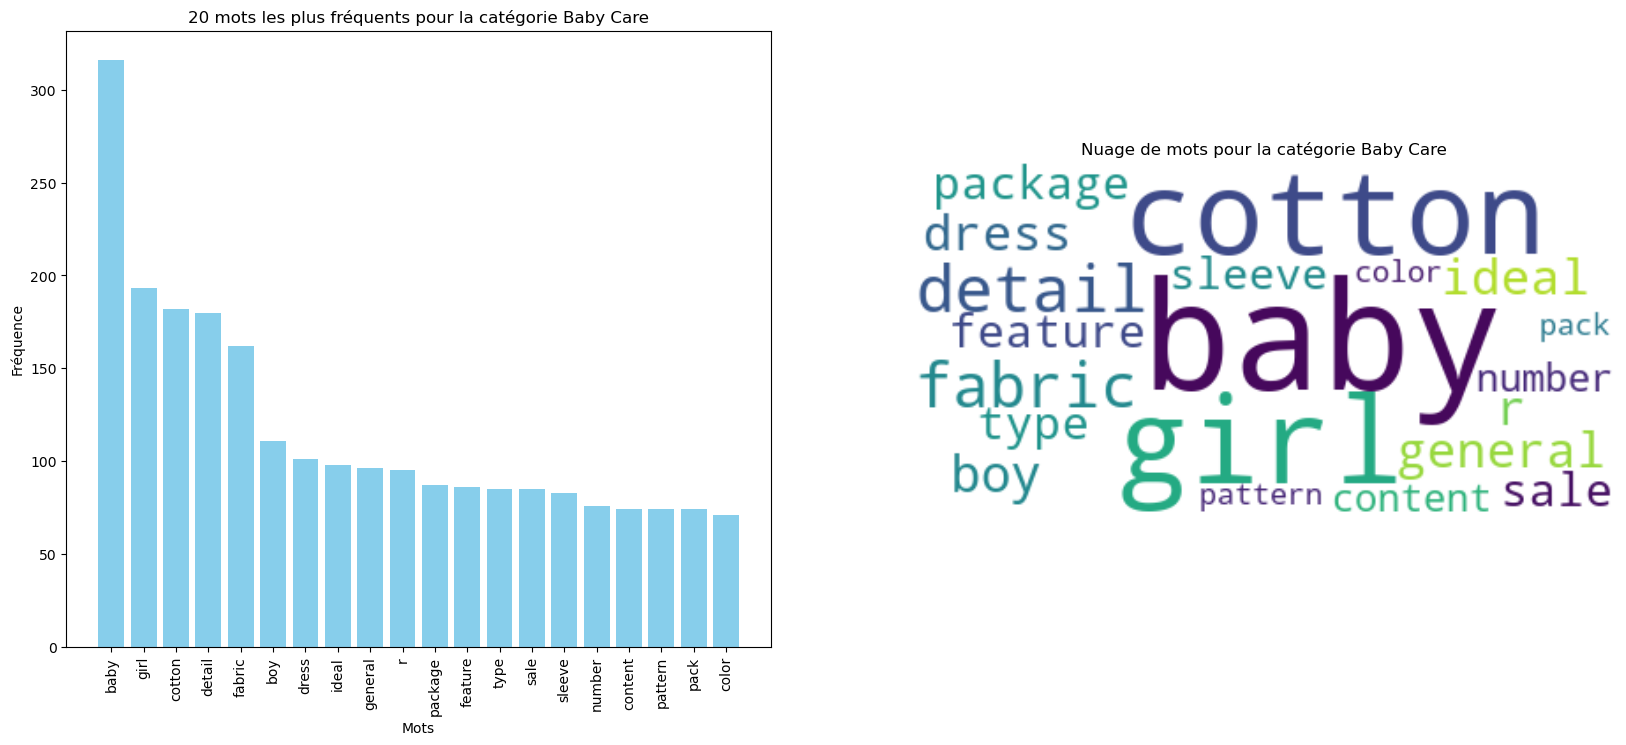

Pour la catégorie Beauty and Personal Care
nb tokens 5772, nb tokens uniques 956
['key', 'feature', 'burt', 'bee', 'hair', 'repair', 'shea', 'grapefruit', 'deep', 'conditioner', 'ideal', 'boy', 'girl', 'applied', 'deep', 'conditioning', 'hair', 'condition', 'damaged', 'hair', 'hair', 'type', 'dry', 'hairspecifications', 'burt', 'bee', 'hair', 'repair', 'shea', 'grapefruit']


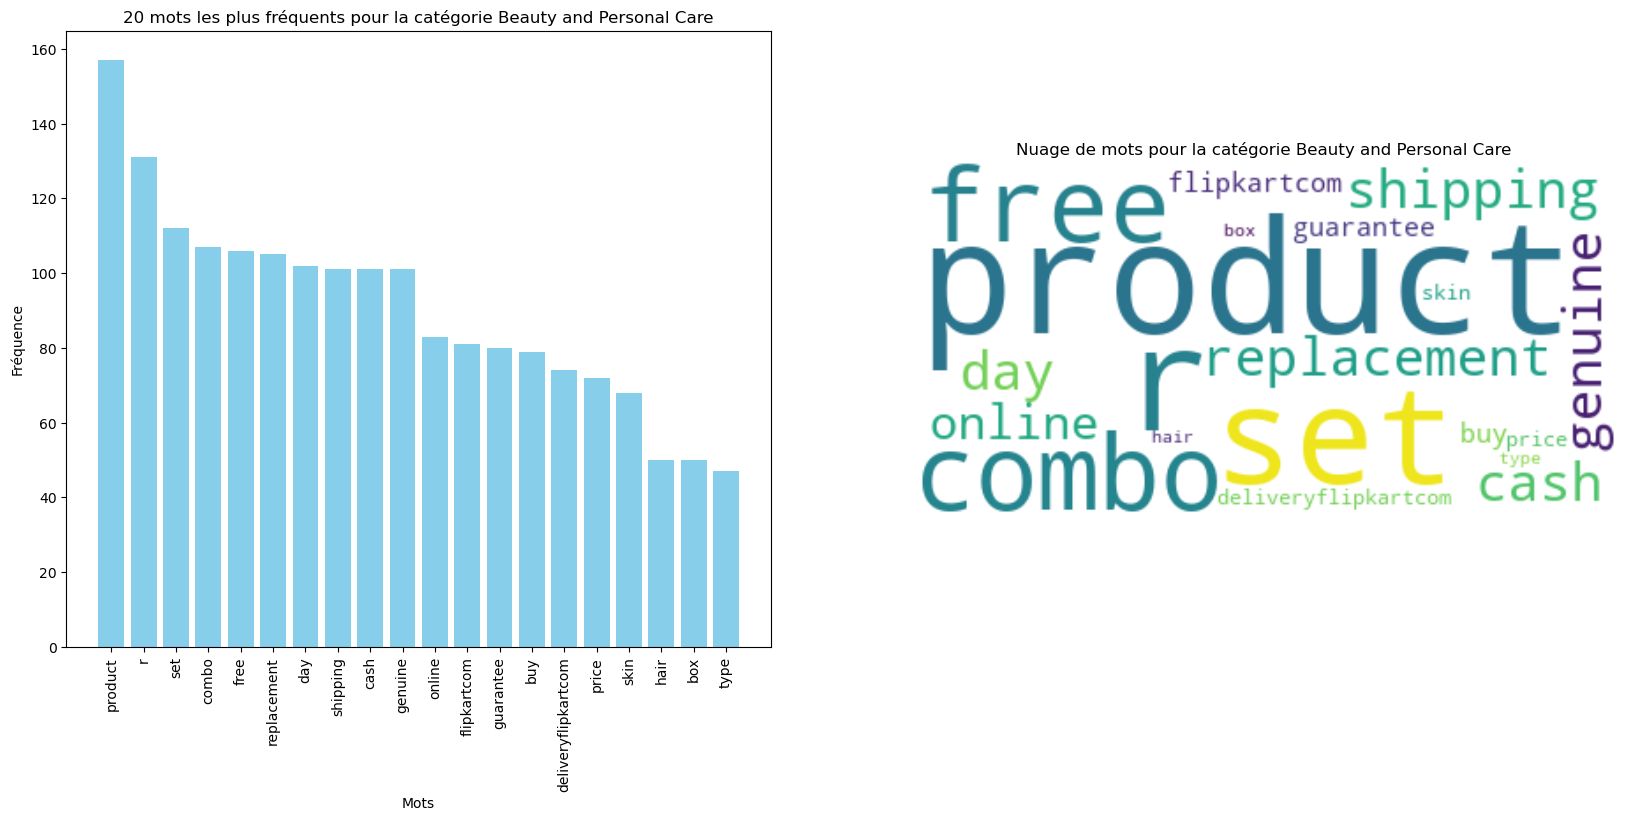

Pour la catégorie Computers
nb tokens 8709, nb tokens uniques 932
['key', 'feature', 'dlink', 'dap', 'dlink', 'dap', 'white', 'speed', 'wireless', 'speed', 'mbps', 'modem', 'speed', 'mbps', 'general', 'brand', 'dlink', 'box', 'extender', 'plug', 'model', 'dap', 'type', 'range', 'color', 'white', 'warranty', 'covered', 'warranty', 'damage']


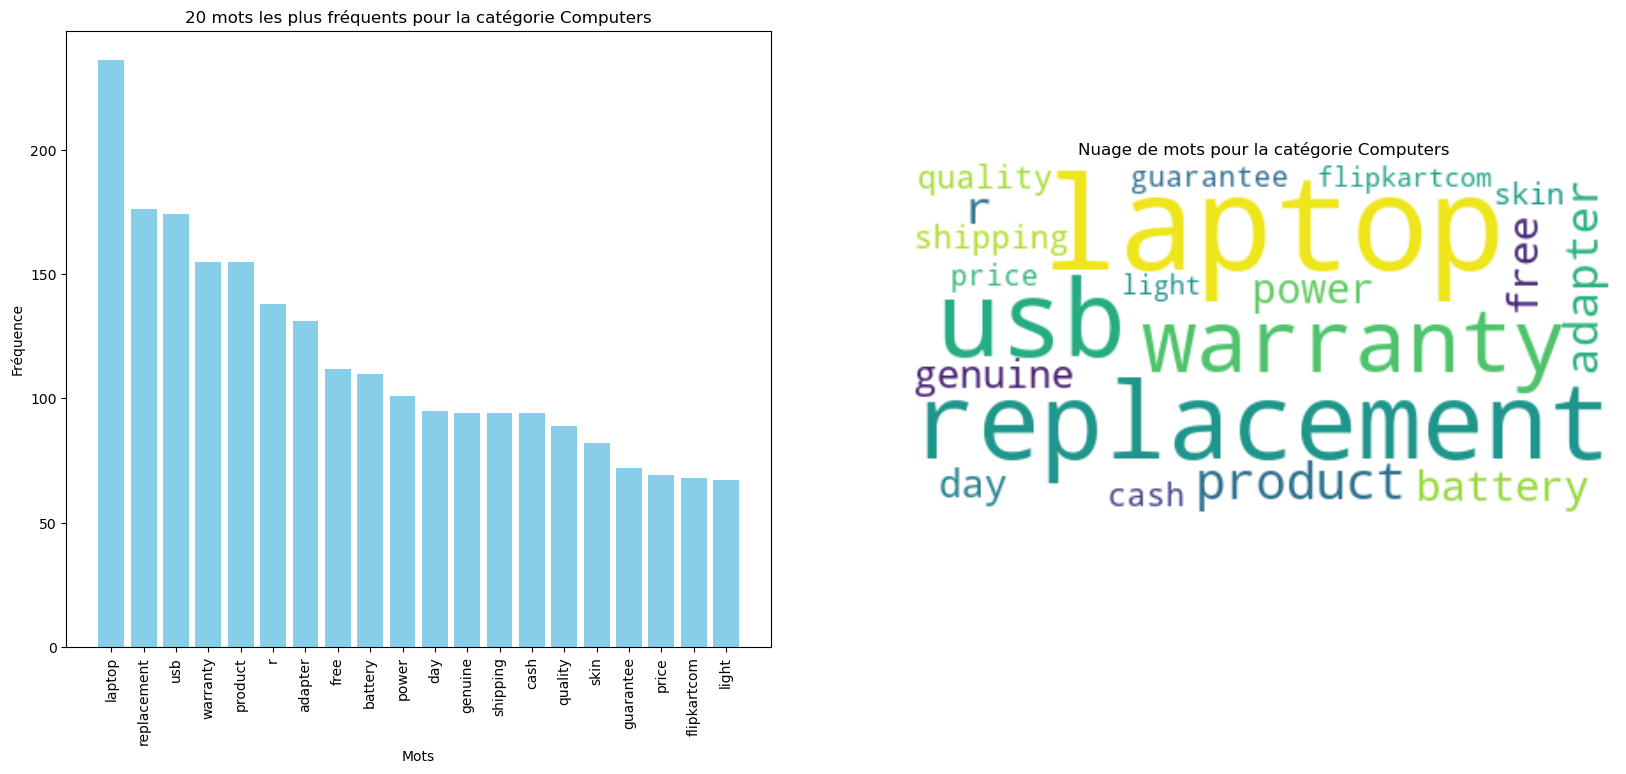

Pour la catégorie Home Decor & Festive Needs
nb tokens 8662, nb tokens uniques 1317
['myesquire', 'ceramic', 'burner', 'pot', 'lemongrass', 'liquid', 'air', 'ml', 'price', 'r', 'illuminate', 'every', 'corner', 'living', 'room', 'style', 'home', 'fragrance', 'electric', 'burner', 'combo', 'fragrance', 'brought', 'myesquire', 'unique', 'useful', 'value', 'money', 'product', 'home']


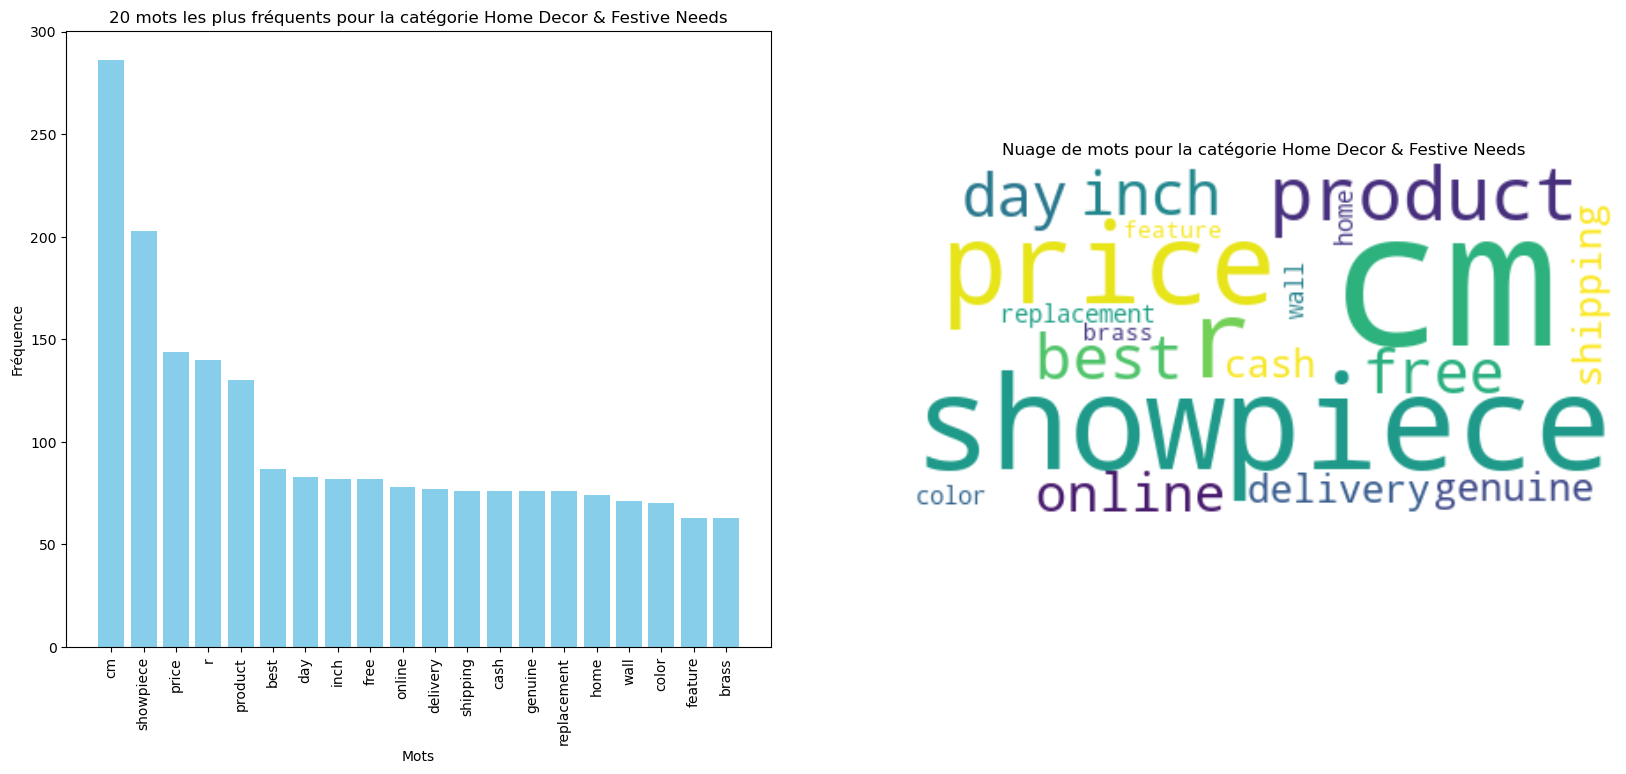

Pour la catégorie Home Furnishing
nb tokens 6112, nb tokens uniques 743
['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'cm', 'height', 'pack', 'price', 'r', 'curtain', 'enhances', 'look', 'curtain', 'made', 'high', 'quality', 'polyester', 'feature']


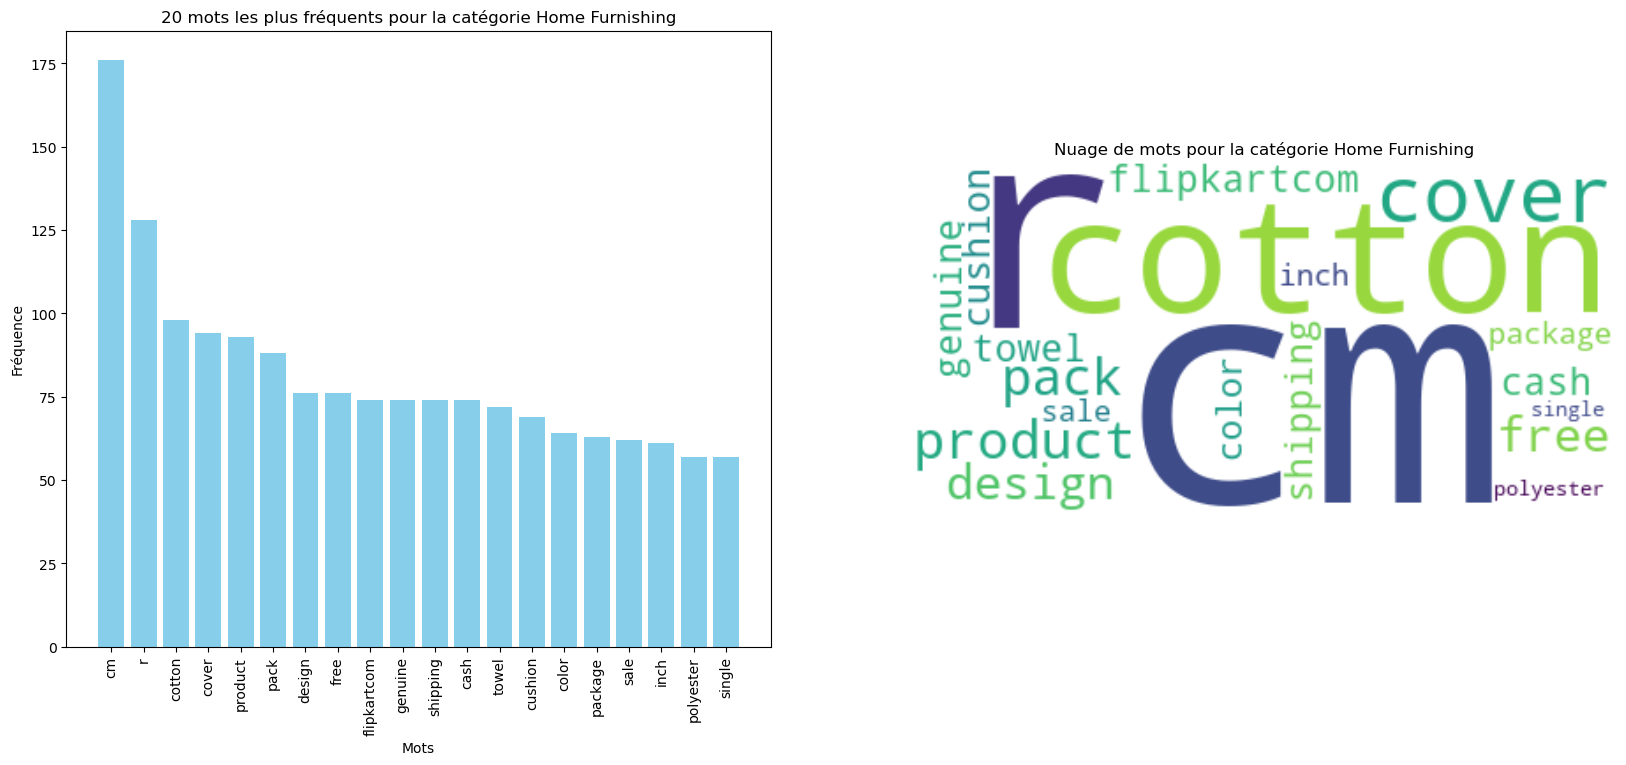

Pour la catégorie Kitchen & Dining
nb tokens 9691, nb tokens uniques 1011
['key', 'feature', 'dungri', 'india', 'craft', 'ducjugducgl', 'jug', 'glass', 'set', 'jug', 'height', 'inch', 'dia', 'inch', 'depth', 'inch', 'width', 'ml', 'weight', 'india', 'craft', 'ducjugducgl', 'jug', 'glass', 'set', 'copper', 'price', 'r', 'copper', 'utensil']


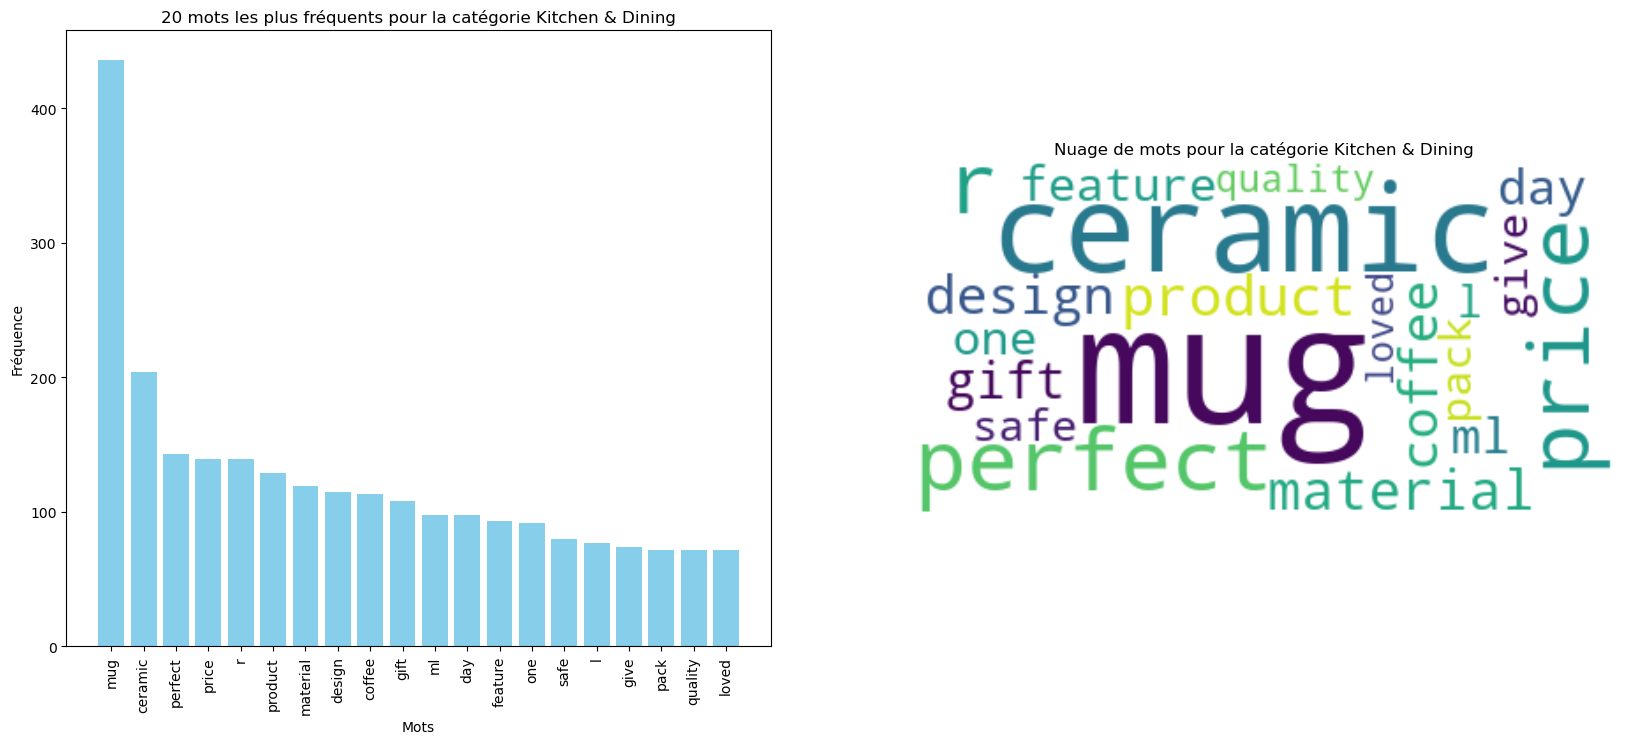

Pour la catégorie Watches
nb tokens 5180, nb tokens uniques 493
['time', 'r', 'analog', 'watch', 'boy', 'buy', 'time', 'r', 'analog', 'watch', 'boy', 'r', 'online', 'r', 'india', 'flipkartcom', 'great', 'discount', 'genuine', 'product', 'day', 'replacement', 'guarantee', 'free', 'shipping', 'cash', 'wm', 'elegance', 'analog', 'watch']


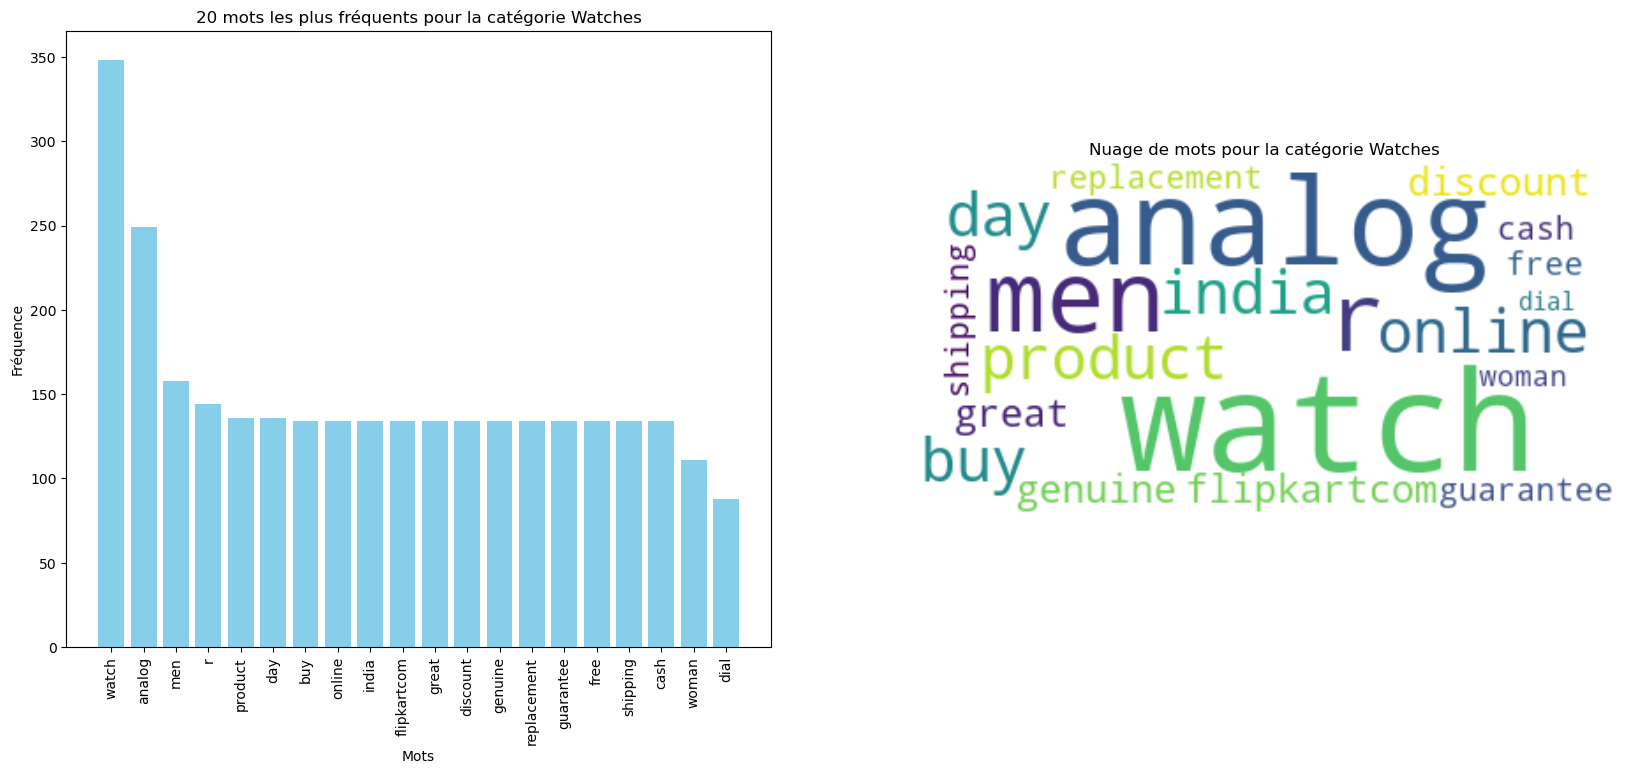

In [57]:
# Itérer sur chaque catégorie de produit
for category, group in df.groupby('product_category'):
    # Aplatir la liste de listes en une seule liste de tokens pour la catégorie actuelle
    all_tokens = [token for sublist in group['description'] for token in sublist]
    cat_corpus = "".join(all_tokens)

    # Traiter des données
    processed_cat_corpus = process_text(cat_corpus, clean=True, tokenize_method='word_tokenize',
                                        remove_stopwords=True, stemming=False,
                                        lemmatization=True, words_to_remove=hapaxes)
    print(f'Pour la catégorie {category}')
    display_tokens_info(processed_cat_corpus)
    
    # Calculer la distribution de fréquence des tokens pour la catégorie
    freq_dist = FreqDist(processed_cat_corpus)
    
    # 20 mots les plus fréquents pour la catégorie
    common_words = freq_dist.most_common(20)
    
    # Séparation des mots et de leurs fréquences
    words, frequencies = zip(*common_words)
    
    # Préparation des subplots
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    
    # Histogramme
    ax[0].bar(range(len(words)), frequencies, color='skyblue')
    ax[0].set_xlabel('Mots')
    ax[0].set_ylabel('Fréquence')
    ax[0].set_xticks(range(len(words)))
    ax[0].set_xticklabels(words, rotation=90)
    ax[0].set_title(f'20 mots les plus fréquents pour la catégorie {category}')
    
    # Création d'un nuage de mots pour la catégorie
    common_words_dict = dict(common_words)
    wordcloud = WordCloud(width=400, height=200, background_color='white',
                          min_font_size=10).generate_from_frequencies(common_words_dict)
    
    # Affichage du nuage de mots
    ax[1].imshow(wordcloud, interpolation="bilinear")
    ax[1].axis('off')
    ax[1].set_title(f'Nuage de mots pour la catégorie {category}')
    
    plt.show()

# Transformation des données

In [58]:
# Traitement de chaque document avec process_text et stockage des résultats dans une nouvelle liste
processed_docs = [process_text(doc, clean=True, tokenize_method='word_tokenize', remove_stopwords=True,
                               stemming=False, lemmatization=True, words_to_remove=hapaxes) for doc in df['description']]

preprocessed_texts = [" ".join(doc) for doc in processed_docs]

In [59]:
preprocessed_texts[:3]

['key feature elegance polyester multicolor abstract eyelet door curtain floral polyester multicolor abstract eyelet door curtain cm height pack price r curtain enhances look curtain made high quality polyester feature eyelet style stitch metal make room environment curtain ant anti shrinkage elegant home bright appeal design attention sure heart contemporary eyelet curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw evening create special moment beauty given soothing print bring home elegant curtain light room get right amount elegance polyester multicolor abstract eyelet door curtain cm height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model id color multicolor dimension length cm box number content sale package pack sale package curtain body design material polyester',
 'specification sathiyas cotton bath towel bath towel red yellow blue bath towel feature machi

## Seuils de fréquences

In [60]:
# Calcul de la fréquence documentaire pour chaque mot
word_doc_freq = {}
for tokens in processed_docs:
    unique_tokens = set(tokens)
    for token in unique_tokens:
        word_doc_freq[token] = word_doc_freq.get(token, 0) + 1

# Seuils de fréquence documentaire
min_threshold = 0.002 * len(processed_docs)
max_threshold = 0.5 * len(processed_docs)

# Identification des mots en dehors des seuils
high_freq_words = [word for word, freq in word_doc_freq.items() if freq > max_threshold]
low_freq_words = [word for word, freq in word_doc_freq.items() if freq < min_threshold]

print("Mots avec une fréquence documentaire supérieure à 0.5 :", high_freq_words)
print("Mots avec une fréquence documentaire inférieur à 0.002 :", low_freq_words[:20])

Mots avec une fréquence documentaire supérieure à 0.5 : ['price', 'r', 'product', 'free', 'shipping', 'delivery', 'genuine', 'buy', 'cash']
Mots avec une fréquence documentaire inférieur à 0.002 : ['given', 'shrinkage', 'welcome', 'slide', 'stitch', 'apart', 'sathiyas', 'absorbency', 'softness', 'eurospa', 'feeling', 'shuvampcftsetassorted', 'exporting', 'santosh', 'gifted', 'returne', 'origional', 'waranty', 'machinewash', 'wm']


In [61]:
# Vérifiez le seuil calculé
print("Seuil (min_threshold) :", min_threshold)
print("Seuil (max_threshold) :", max_threshold)

Seuil (min_threshold) : 2.1
Seuil (max_threshold) : 525.0


In [62]:
# Concaténation des listes
combined_list = hapaxes + high_freq_words + low_freq_words

In [63]:
# Traitement de chaque document avec process_text et stockage des résultats dans une nouvelle liste
processed_docs = [process_text(doc, clean=True, tokenize_method='word_tokenize', remove_stopwords=True,
                               stemming=False, lemmatization=True, words_to_remove=combined_list) for doc in df['description']]

preprocessed_texts = [" ".join(doc) for doc in processed_docs]

<b>Effets de l'appplication des seuils sur les nuages de mots par catégories</b>

Pour la catégorie Baby Care
nb tokens 7058, nb tokens uniques 729
['specification', 'cotton', 'bath', 'towel', 'bath', 'towel', 'red', 'yellow', 'blue', 'bath', 'towel', 'feature', 'machine', 'washable', 'yes', 'material', 'cotton', 'design', 'self', 'design', 'general', 'brand', 'type', 'bath', 'towel', 'gsm', 'model', 'name', 'cotton', 'bath']


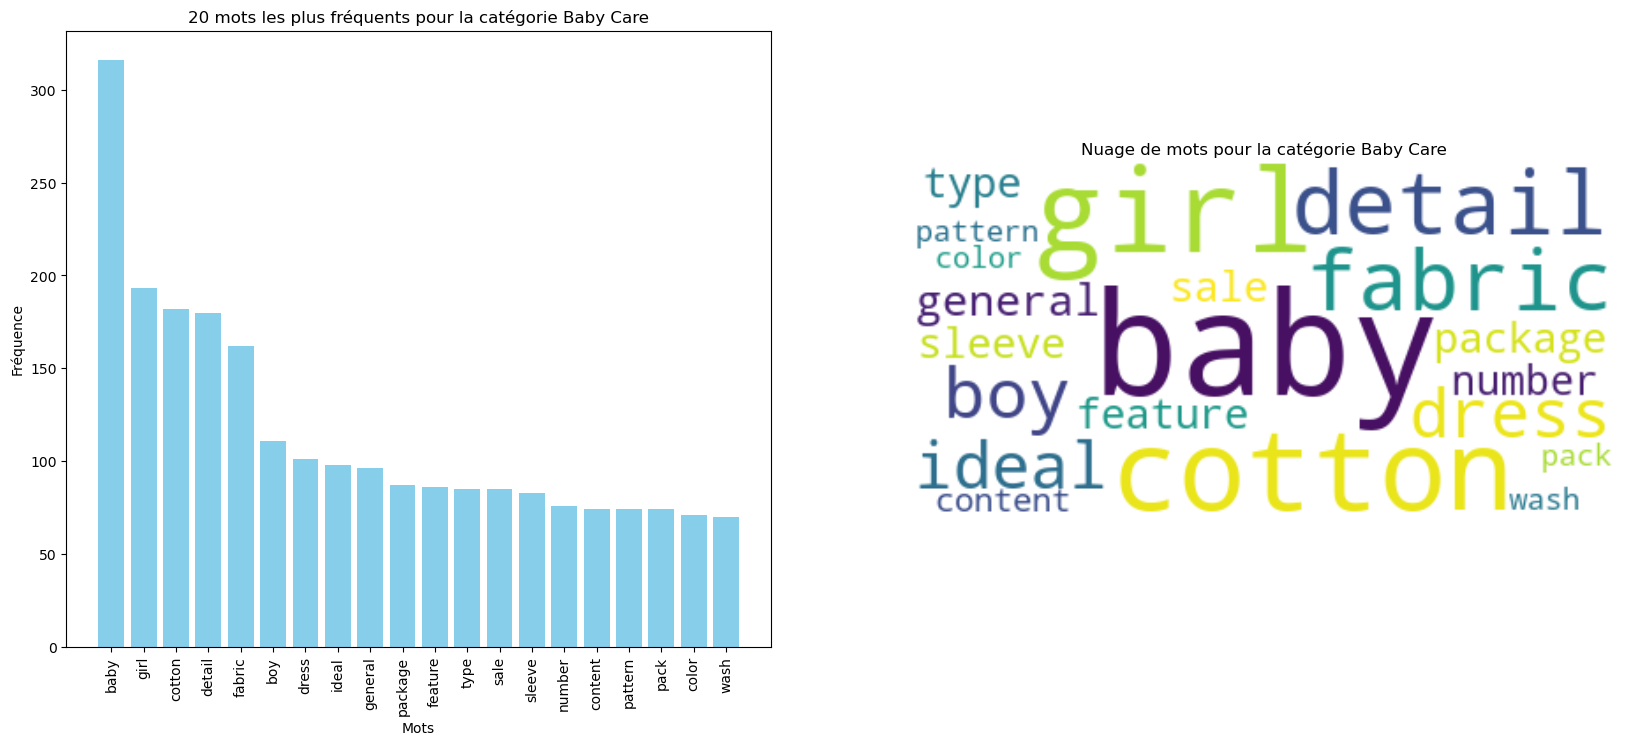

Pour la catégorie Beauty and Personal Care
nb tokens 4111, nb tokens uniques 626
['key', 'feature', 'hair', 'repair', 'deep', 'conditioner', 'ideal', 'boy', 'girl', 'applied', 'deep', 'hair', 'condition', 'damaged', 'hair', 'hair', 'type', 'dry', 'hair', 'repair', 'deep', 'conditioner', 'ml', 'conditioner', 'trait', 'hair', 'condition', 'damaged', 'hair', 'hair']


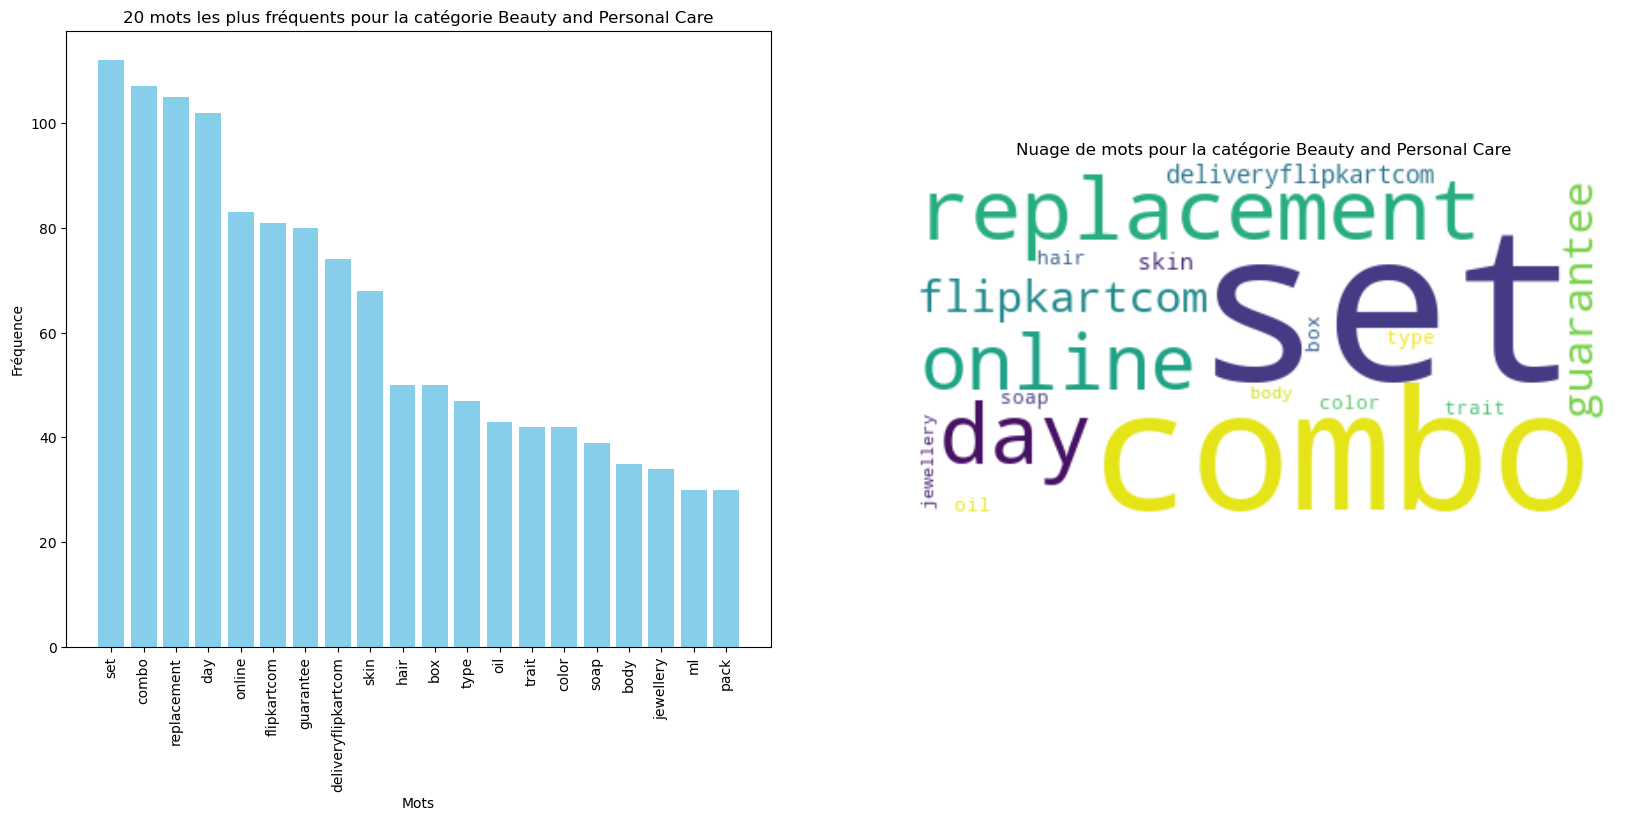

Pour la catégorie Computers
nb tokens 7067, nb tokens uniques 612
['key', 'feature', 'dlink', 'dlink', 'white', 'speed', 'wireless', 'speed', 'mbps', 'modem', 'speed', 'mbps', 'general', 'brand', 'dlink', 'box', 'extender', 'plug', 'model', 'type', 'range', 'color', 'white', 'warranty', 'covered', 'warranty', 'damage', 'warranty', 'summary', 'year']


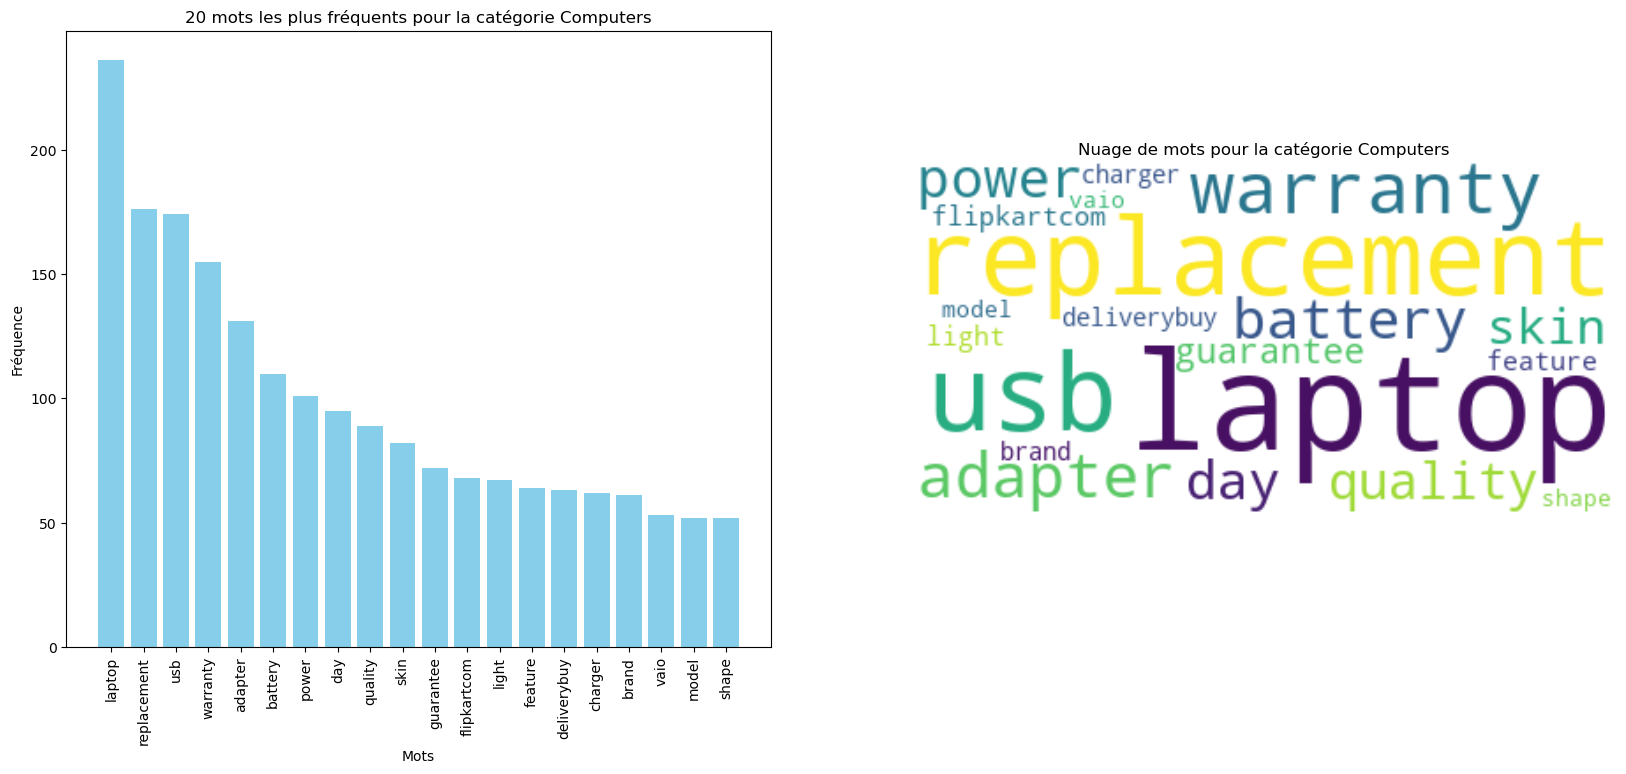

Pour la catégorie Home Decor & Festive Needs
nb tokens 6616, nb tokens uniques 811
['ceramic', 'pot', 'liquid', 'air', 'ml', 'every', 'corner', 'living', 'room', 'style', 'home', 'fragrance', 'combo', 'fragrance', 'unique', 'useful', 'home', 'decoration', 'fragrance', 'unique', 'combo', 'contains', 'aroma', 'accessory', 'ready', 'use', 'put', 'small', 'amount', 'tea']


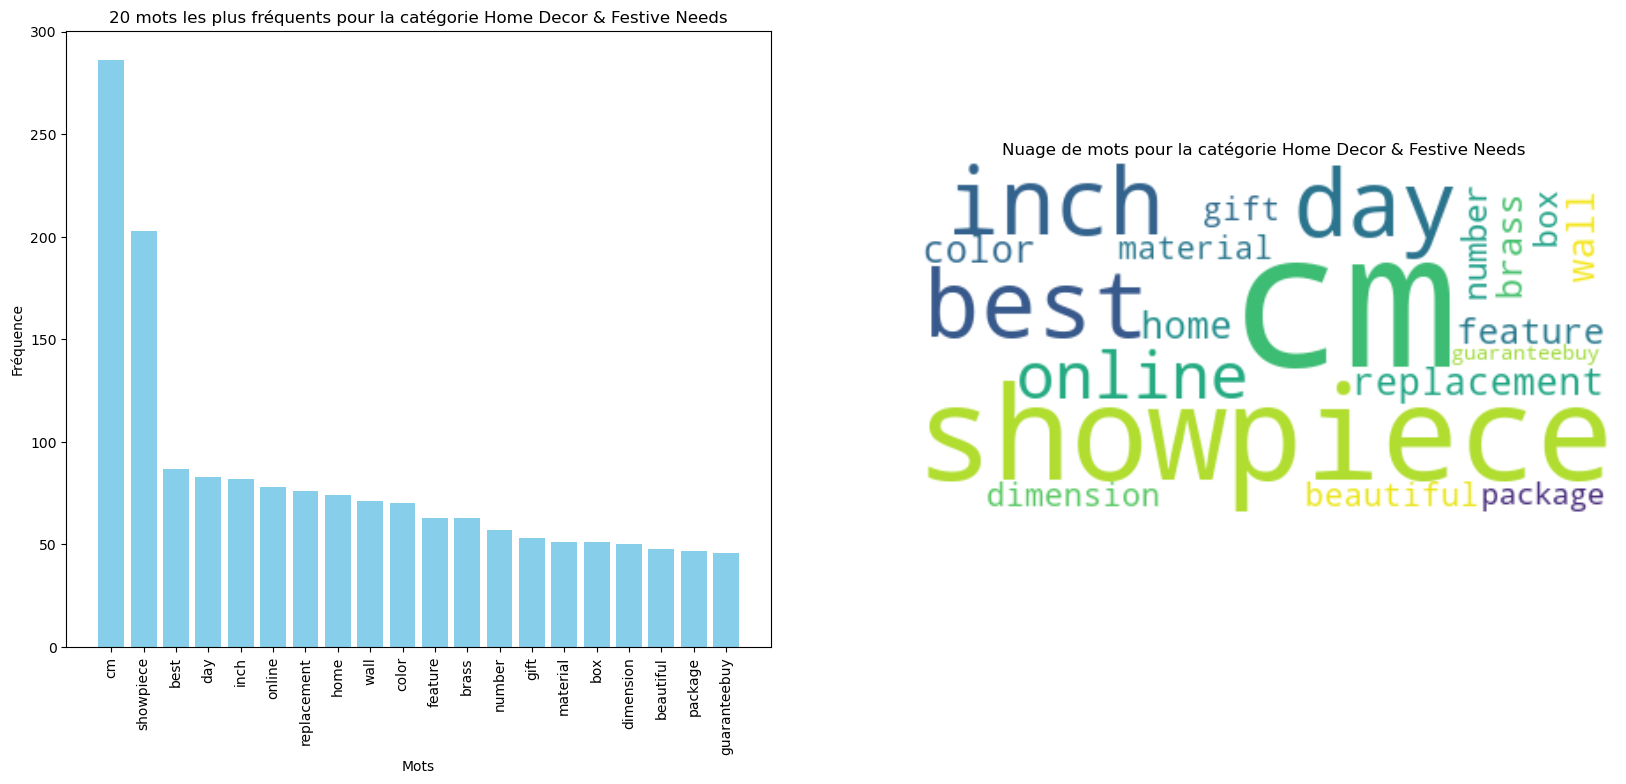

Pour la catégorie Home Furnishing
nb tokens 5094, nb tokens uniques 542
['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'cm', 'height', 'pack', 'curtain', 'enhances', 'look', 'curtain', 'made', 'high', 'quality', 'polyester', 'feature', 'eyelet', 'style']


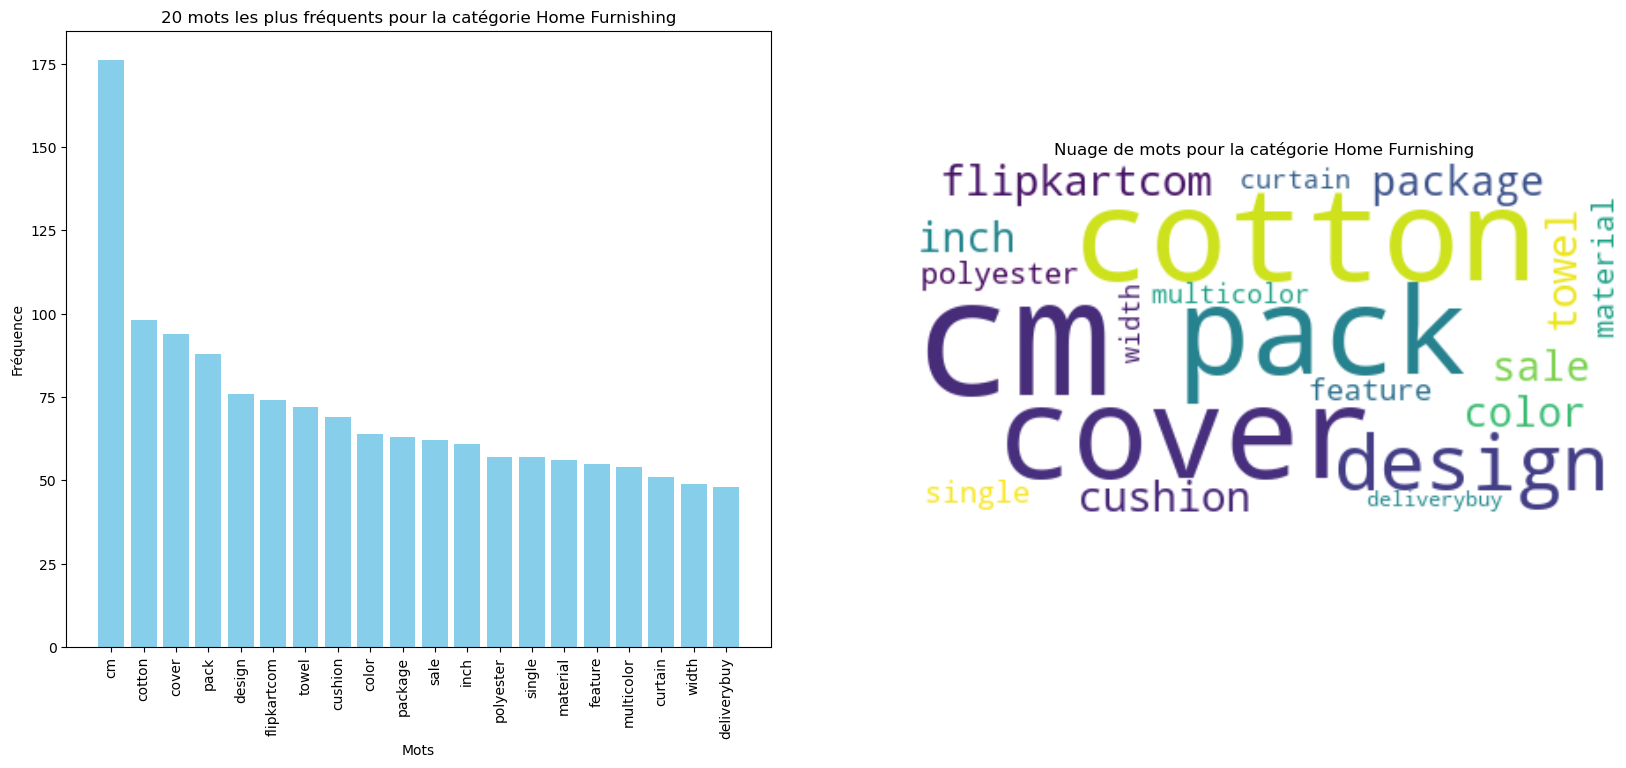

Pour la catégorie Kitchen & Dining
nb tokens 8151, nb tokens uniques 662
['key', 'feature', 'india', 'craft', 'glass', 'set', 'height', 'inch', 'dia', 'inch', 'depth', 'inch', 'width', 'ml', 'weight', 'india', 'craft', 'glass', 'set', 'copper', 'copper', 'utensil', 'serving', 'copper', 'prevent', 'spread', 'disease', 'many', 'copper', 'surface']


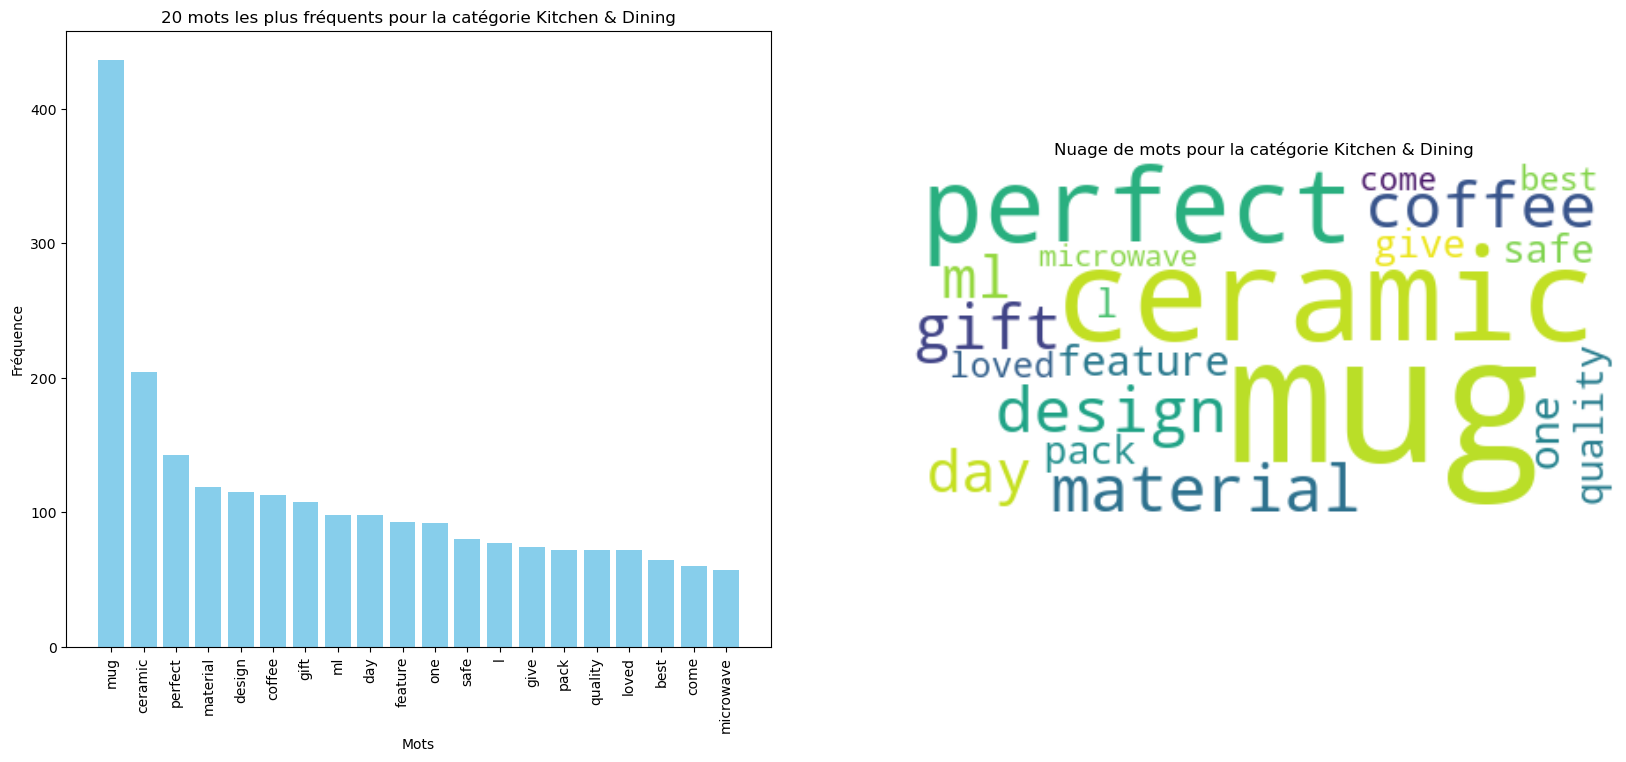

Pour la catégorie Watches
nb tokens 3754, nb tokens uniques 299
['time', 'analog', 'watch', 'boy', 'time', 'analog', 'watch', 'boy', 'online', 'india', 'flipkartcom', 'great', 'discount', 'day', 'replacement', 'guarantee', 'elegance', 'analog', 'watch', 'men', 'boy', 'elegance', 'analog', 'watch', 'men', 'boy', 'online', 'india', 'flipkartcom', 'great']


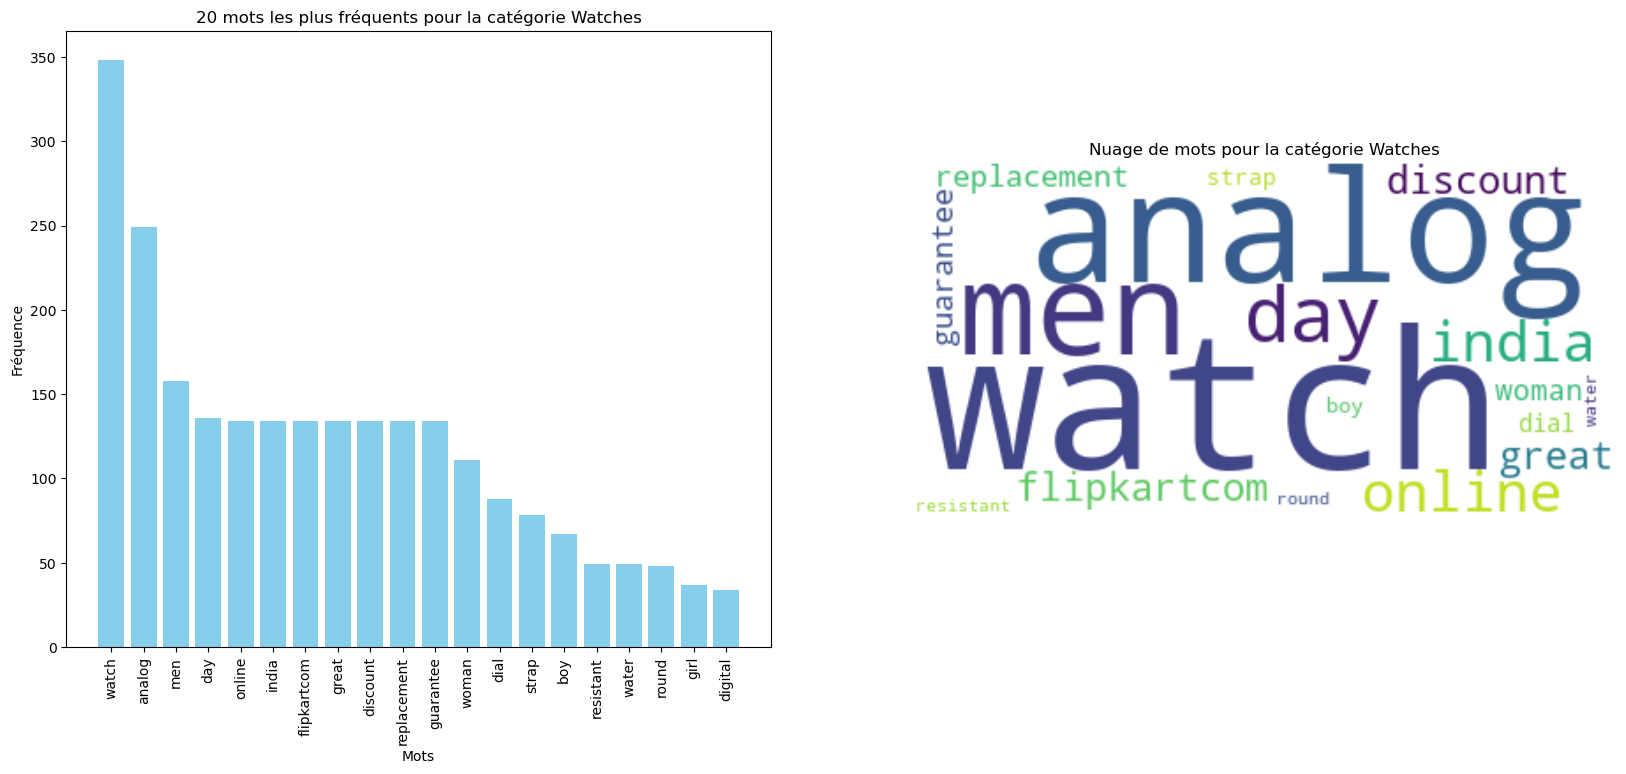

In [64]:
# Itérer sur chaque catégorie de produit
for category, group in df.groupby('product_category'):
    # Aplatir la liste de listes en une seule liste de tokens pour la catégorie actuelle
    all_tokens = [token for sublist in group['description'] for token in sublist]
    cat_corpus = "".join(all_tokens)

    # Traiter des données
    processed_cat_corpus = process_text(cat_corpus, clean=True, tokenize_method='word_tokenize',
                                        remove_stopwords=True, stemming=False,
                                        lemmatization=True, words_to_remove=combined_list)
    print(f'Pour la catégorie {category}')
    display_tokens_info(processed_cat_corpus)
    
    # Calculer la distribution de fréquence des tokens pour la catégorie
    freq_dist = FreqDist(processed_cat_corpus)
    
    # 20 mots les plus fréquents pour la catégorie
    common_words = freq_dist.most_common(20)
    
    # Séparation des mots et de leurs fréquences
    words, frequencies = zip(*common_words)
    
    # Préparation des subplots
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    
    # Histogramme
    ax[0].bar(range(len(words)), frequencies, color='skyblue')
    ax[0].set_xlabel('Mots')
    ax[0].set_ylabel('Fréquence')
    ax[0].set_xticks(range(len(words)))
    ax[0].set_xticklabels(words, rotation=90)
    ax[0].set_title(f'20 mots les plus fréquents pour la catégorie {category}')
    
    # Création d'un nuage de mots pour la catégorie
    common_words_dict = dict(common_words)
    wordcloud = WordCloud(width=400, height=200, background_color='white',
                          min_font_size=10).generate_from_frequencies(common_words_dict)
    
    # Affichage du nuage de mots
    ax[1].imshow(wordcloud, interpolation="bilinear")
    ax[1].axis('off')
    ax[1].set_title(f'Nuage de mots pour la catégorie {category}')
    
    plt.show()

## Bag of Words

In [65]:
vectorizer_bow = CountVectorizer(min_df=0.002, max_df=0.5)
bow_matrix = vectorizer_bow.fit_transform(preprocessed_texts)

In [66]:
bow_matrix.shape

(1050, 1459)

## Tf-idf

In [67]:
vectorizer_tfidf = TfidfVectorizer(min_df=0.002, max_df=0.5)
tfidf_matrix = vectorizer_tfidf.fit_transform(preprocessed_texts)

In [68]:
tfidf_matrix.shape

(1050, 1459)

## Word2Vec

In [69]:
# Training the Word2Vec model
model = Word2Vec(sentences=processed_docs, vector_size=300, window=5, min_count=2, workers=4,
                sg=1, 
                hs=0, 
                negative=5, 
                epochs=50, 
                alpha=0.025, 
                sample=1e-4,
                seed=42)

# Summarize the loaded model
print(model)

Word2Vec<vocab=1471, vector_size=300, alpha=0.025>


In [70]:
def document_vector(word2vec_model, doc):
    # Suppression des mots hors vocabulaire
    doc = [word for word in doc if word in word2vec_model.wv.key_to_index]
    return np.mean(word2vec_model.wv[doc], axis=0)

# Création de la matrice de caractéristiques pour les documents
doc_vectors = np.array([document_vector(model, doc) for doc in processed_docs])

## BERT

In [71]:
# Chargement du tokenizer et du modèle
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [72]:
def encode_documents(docs, tokenizer, model, batch_size=10, device='cuda'):
    model.to(device)
    embeddings = []

    for i in range(0, len(docs), batch_size):
        batch = docs[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors='pt', max_length=512, padding='max_length', truncation=True)
        inputs = {key: val.to(device) for key, val in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        # Prendre le CLS token embedding
        # cls_embeddings = outputs.last_hidden_state[:, 0, :]
        # embeddings.append(cls_embeddings.cpu())  

        # Max pooling
        max_pooled_embeddings = torch.max(outputs.last_hidden_state, dim=1).values
        embeddings.append(max_pooled_embeddings.cpu())

        # Moyenne des états cachés pour obtenir l'embedding du document
        # batch_embeddings = outputs.last_hidden_state.mean(1)
        # embeddings.append(batch_embeddings.cpu())  
    
    # Concatenate all embeddings
    embeddings = torch.cat(embeddings)

    embeddings = embeddings.numpy()

    return embeddings

In [73]:
embeddings_matrix = encode_documents(df['description'].tolist(), tokenizer, model, batch_size=16, device='cuda')

In [74]:
embeddings_matrix[:2]

array([[1.8485999 , 1.5761065 , 1.7227316 , ..., 0.9317669 , 1.2591282 ,
        1.3741595 ],
       [1.4562503 , 1.1756341 , 1.6559561 , ..., 0.45801473, 0.66112787,
        1.0761094 ]], dtype=float32)

## Universal Sentence Encoder (USE)

In [80]:
# Chargement du modèle Universal Sentence Encoder version 3
embed = hub.load("https://kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/1")

def encode_document_with_USE(doc):
    # Utilisation de l'API pour charger le modèle et obtenir les embeddings
    return embed([doc])['outputs']

# Encodage de tous les documents et conversion en array numpy
doc_embeddings_USE = np.array([encode_document_with_USE(doc).numpy()[0] for doc in preprocessed_texts])

In [81]:
print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__)

TensorFlow version: 2.16.1
TensorFlow Hub version: 0.16.1


In [82]:
doc_embeddings_USE[:3]

array([[-0.05546733, -0.05502984,  0.04439797, ...,  0.04980377,
         0.0490019 , -0.04824112],
       [-0.03087286, -0.04535445, -0.00206622, ...,  0.04139815,
         0.02731982,  0.02293224],
       [-0.05420507, -0.04670093, -0.03769447, ...,  0.04959925,
        -0.00161115, -0.02738835]], dtype=float32)

## LDA

In [83]:
# Création du dictionnaire
dictionary = corpora.Dictionary(processed_docs)

# Conversion en corpus bag-of-words
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Application de LDA
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=7, random_state=42,
                     update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

# Extraction de la matrice de distribution des topics
topic_distribution = lda_model.get_document_topics(corpus, minimum_probability=0)

# Convertir la liste de tuples en matrice numpy
topic_matrix = np.array([[prob for _, prob in doc] for doc in topic_distribution])

In [84]:
topic_matrix[:3]

array([[0.05806602, 0.5241431 , 0.00086188, 0.04104629, 0.00217635,
        0.00116388, 0.3725425 ],
       [0.00267826, 0.00259639, 0.0018382 , 0.00210744, 0.03015888,
        0.6761476 , 0.28447324],
       [0.23629917, 0.00118695, 0.01416796, 0.00095728, 0.01399944,
        0.50949305, 0.22389619]], dtype=float32)

## NMF

In [85]:
# Application de NMF
nmf_model = NMF(n_components=7, random_state=42, l1_ratio=.5, init='nndsvd')
nmf_matrix = nmf_model.fit_transform(tfidf_matrix) 

C:\Users\estel\anaconda3\envs\OC\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [86]:
nmf_matrix[:3]

array([[0.        , 0.        , 0.        , 0.00404551, 0.00701048,
        0.01816566, 0.18485592],
       [0.00435064, 0.        , 0.0262613 , 0.        , 0.00396127,
        0.3631976 , 0.08599557],
       [0.        , 0.        , 0.02524341, 0.00131965, 0.00561208,
        0.29445645, 0.07345443]])

## Réduction de dimension

### ACP

#### Sur BoW

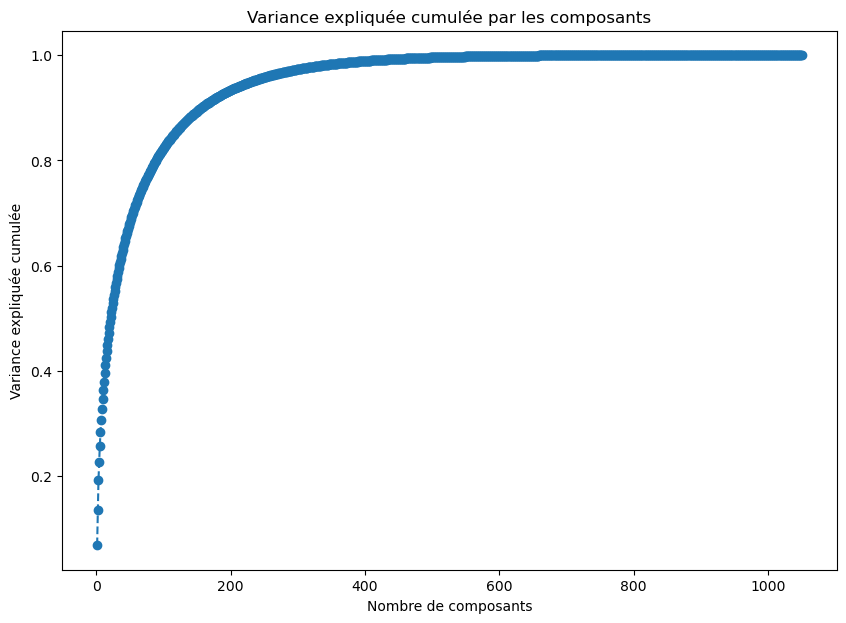

In [87]:
# Création de l'ACP
pca = PCA()

# Application de l'ACP sur les données prétraitées
X_pca = pca.fit_transform(bow_matrix.toarray())

plt.figure(figsize=(10, 7))
plt.plot(range(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_.cumsum(),
         marker='o',
         linestyle='--')
plt.title('Variance expliquée cumulée par les composants')
plt.xlabel('Nombre de composants')
plt.ylabel('Variance expliquée cumulée')
plt.show()

In [88]:
# Calcul de la variance expliquée cumulée
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Trouver le nombre de composantes pour atteindre le seuil de variance expliquée
n_components_99 = np.where(cumulative_variance >= 0.99)[0][0] + 1

print(f"Nombre de composantes pour atteindre 99% de variance expliquée : {n_components_99}")

Nombre de composantes pour atteindre 99% de variance expliquée : 410


In [89]:
# PCA
pca = PCA(n_components=n_components_99)
reduced_bow = pca.fit_transform(bow_matrix.toarray())

#### Sur Tf-idf

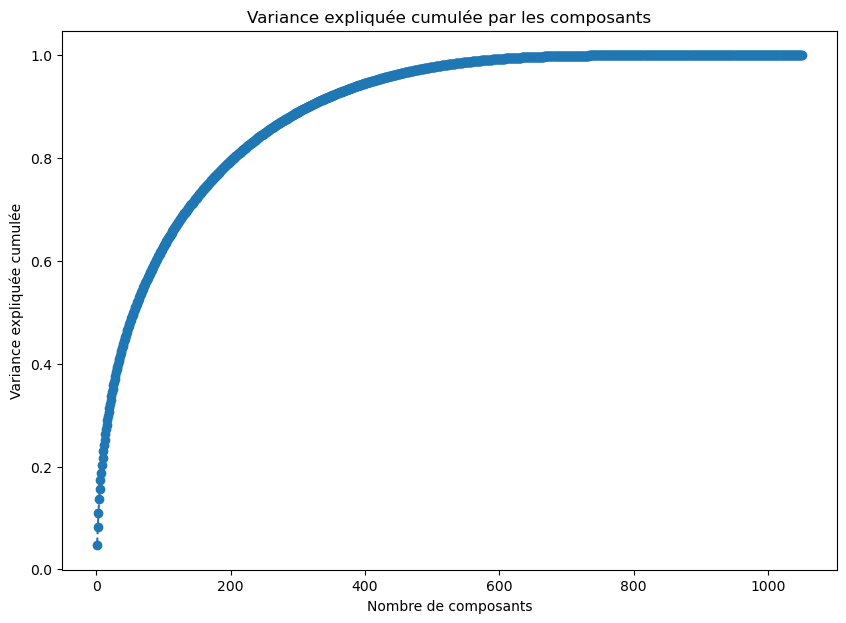

In [90]:
# Création de l'ACP
pca = PCA()

# Application de l'ACP sur les données prétraitées
X_pca = pca.fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(10, 7))
plt.plot(range(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_.cumsum(),
         marker='o',
         linestyle='--')
plt.title('Variance expliquée cumulée par les composants')
plt.xlabel('Nombre de composants')
plt.ylabel('Variance expliquée cumulée')
plt.show()

In [91]:
# Calcul de la variance expliquée cumulée
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Trouver le nombre de composantes pour atteindre le seuil de variance expliquée
n_components_99 = np.where(cumulative_variance >= 0.99)[0][0] + 1

print(f"Nombre de composantes pour atteindre 99% de variance expliquée : {n_components_99}")

Nombre de composantes pour atteindre 99% de variance expliquée : 576


In [92]:
# PCA
pca = PCA(n_components=n_components_99)
reduced_tfidf = pca.fit_transform(tfidf_matrix.toarray())

#### Sur Word2vec

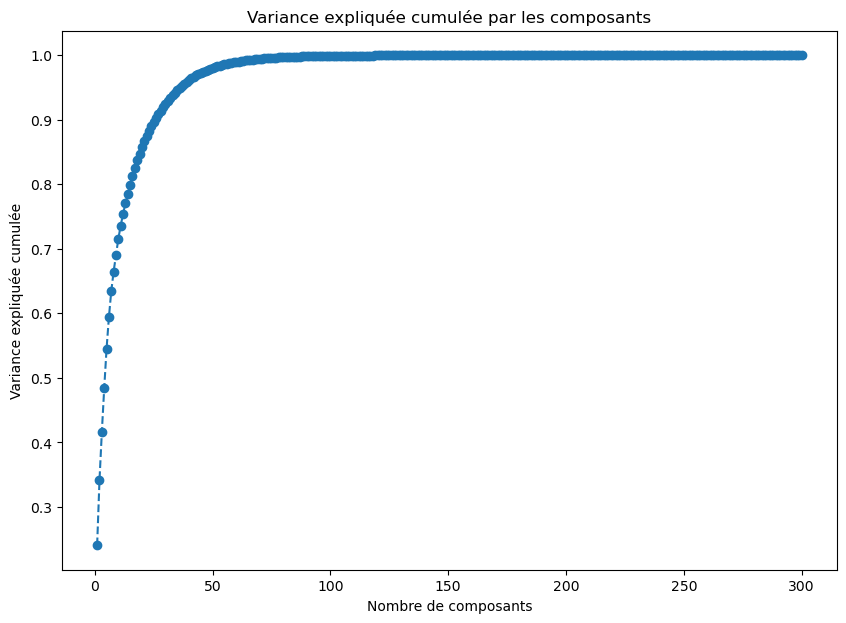

In [93]:
# Création de l'ACP
pca = PCA()

# Application de l'ACP sur les données prétraitées
X_pca = pca.fit_transform(doc_vectors)

plt.figure(figsize=(10, 7))
plt.plot(range(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_.cumsum(),
         marker='o',
         linestyle='--')
plt.title('Variance expliquée cumulée par les composants')
plt.xlabel('Nombre de composants')
plt.ylabel('Variance expliquée cumulée')
plt.show()

In [94]:
# Calcul de la variance expliquée cumulée
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Trouver le nombre de composantes pour atteindre le seuil de variance expliquée
n_components_99 = np.where(cumulative_variance >= 0.99)[0][0] + 1

print(f"Nombre de composantes pour atteindre 99% de variance expliquée : {n_components_99}")

Nombre de composantes pour atteindre 99% de variance expliquée : 61


In [95]:
# PCA
pca = PCA(n_components=n_components_99)
reduced_w2v = pca.fit_transform(doc_vectors)

#### Sur BERT

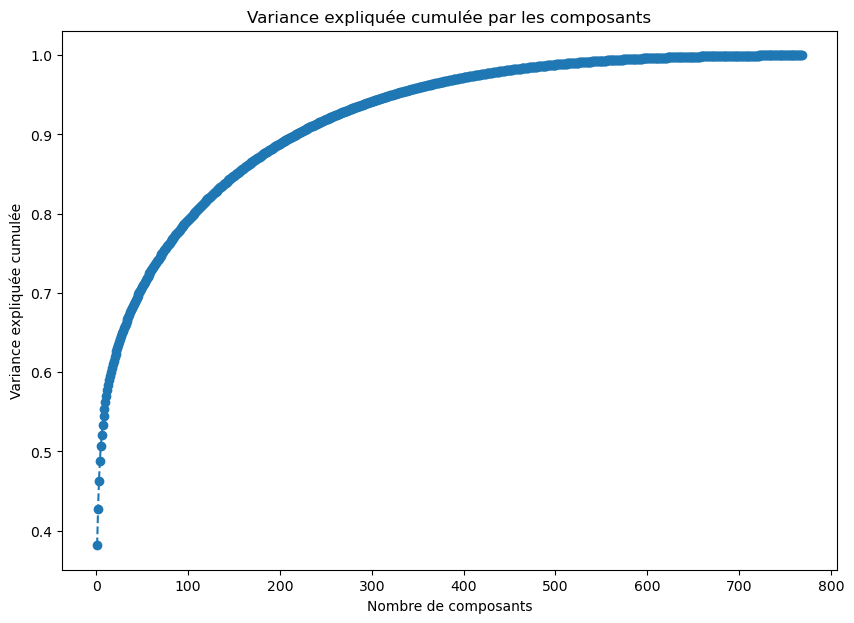

In [96]:
# Création de l'ACP
pca = PCA()

# Application de l'ACP sur les données prétraitées
X_pca = pca.fit_transform(embeddings_matrix)

plt.figure(figsize=(10, 7))
plt.plot(range(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_.cumsum(),
         marker='o',
         linestyle='--')
plt.title('Variance expliquée cumulée par les composants')
plt.xlabel('Nombre de composants')
plt.ylabel('Variance expliquée cumulée')
plt.show()

In [97]:
# Calcul de la variance expliquée cumulée
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Trouver le nombre de composantes pour atteindre le seuil de variance expliquée
n_components_99 = np.where(cumulative_variance >= 0.99)[0][0] + 1

print(f"Nombre de composantes pour atteindre 99% de variance expliquée : {n_components_99}")

Nombre de composantes pour atteindre 99% de variance expliquée : 518


In [98]:
# PCA
pca = PCA(n_components=n_components_99)
reduced_bert = pca.fit_transform(embeddings_matrix)

#### Sur USE

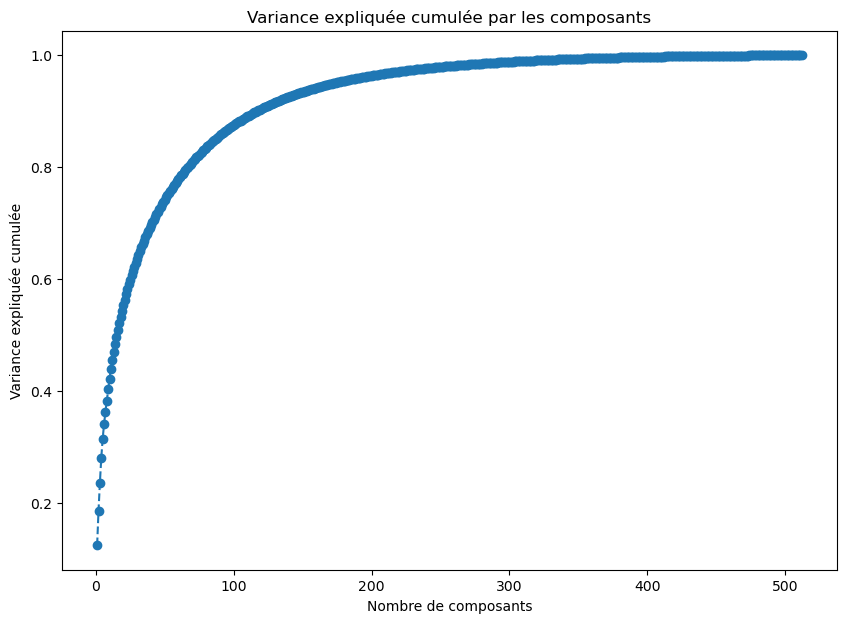

In [99]:
# Création de l'ACP
pca = PCA()

# Application de l'ACP sur les données prétraitées
X_pca = pca.fit_transform(doc_embeddings_USE)

plt.figure(figsize=(10, 7))
plt.plot(range(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_.cumsum(),
         marker='o',
         linestyle='--')
plt.title('Variance expliquée cumulée par les composants')
plt.xlabel('Nombre de composants')
plt.ylabel('Variance expliquée cumulée')
plt.show()

In [100]:
# Calcul de la variance expliquée cumulée
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Trouver le nombre de composantes pour atteindre le seuil de variance expliquée
n_components_99 = np.where(cumulative_variance >= 0.99)[0][0] + 1

print(f"Nombre de composantes pour atteindre 99% de variance expliquée : {n_components_99}")

Nombre de composantes pour atteindre 99% de variance expliquée : 314


In [101]:
# PCA
pca = PCA(n_components=n_components_99)
reduced_use = pca.fit_transform(doc_embeddings_USE)

### T-SNE

In [102]:
# Encodage des catégories
label_encoder = LabelEncoder()
categories_encoded = label_encoder.fit_transform(df['product_category'])
category_names = label_encoder.classes_

#### Sur BoW

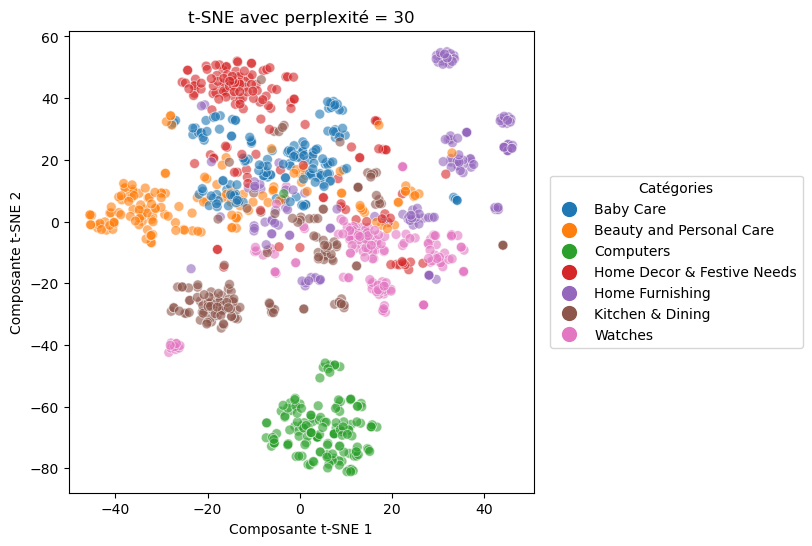

In [103]:
tsne_bow = plot_tsne(bow_matrix.toarray(), categories_encoded, category_names, 30)

#### Sur Tf-idf

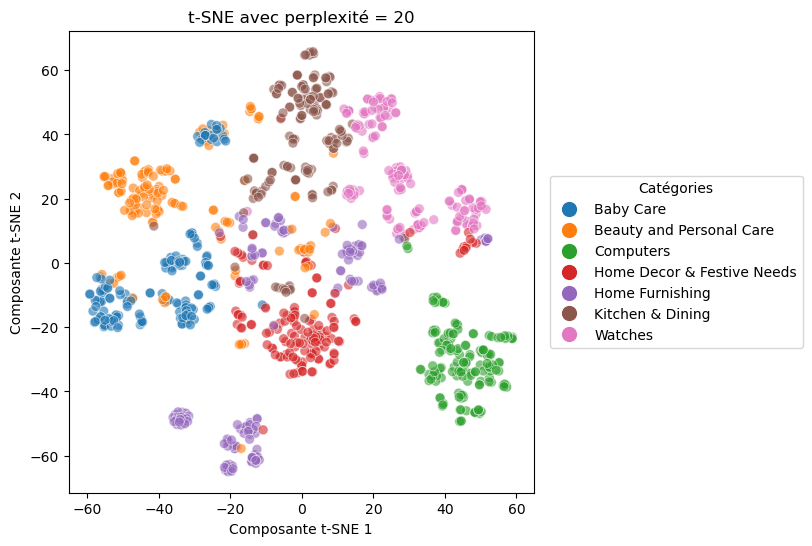

In [104]:
tsne_tfidf = plot_tsne(tfidf_matrix.toarray(), categories_encoded, category_names, 20)

#### Sur Word2vec

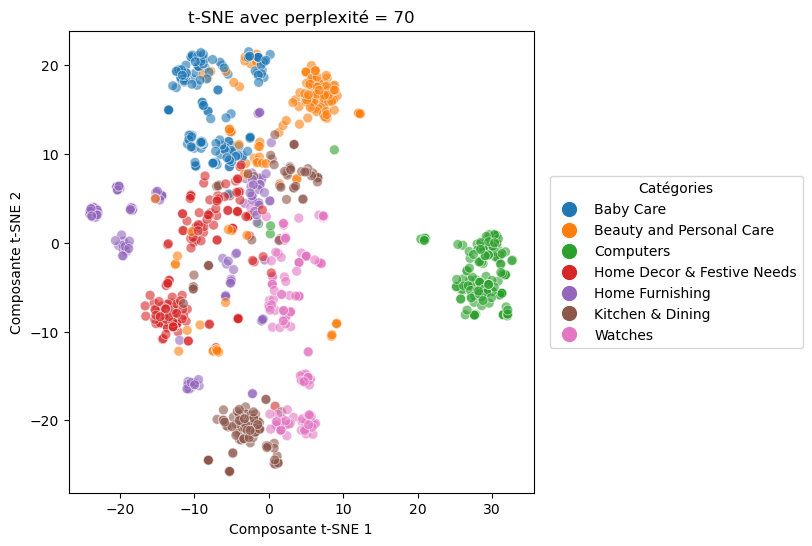

In [105]:
tsne_w2v = plot_tsne(doc_vectors, categories_encoded, category_names, 70)

#### Sur BERT

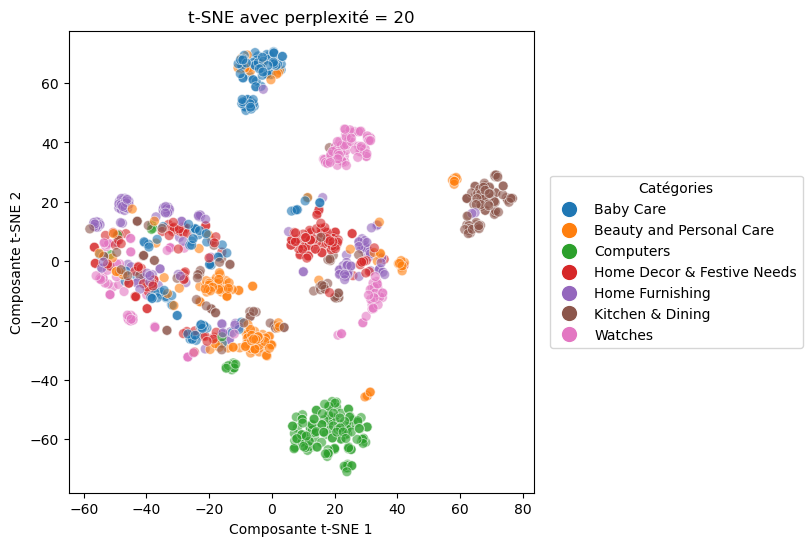

In [106]:
tsne_bert = plot_tsne(embeddings_matrix, categories_encoded, category_names, 20)

#### Sur USE

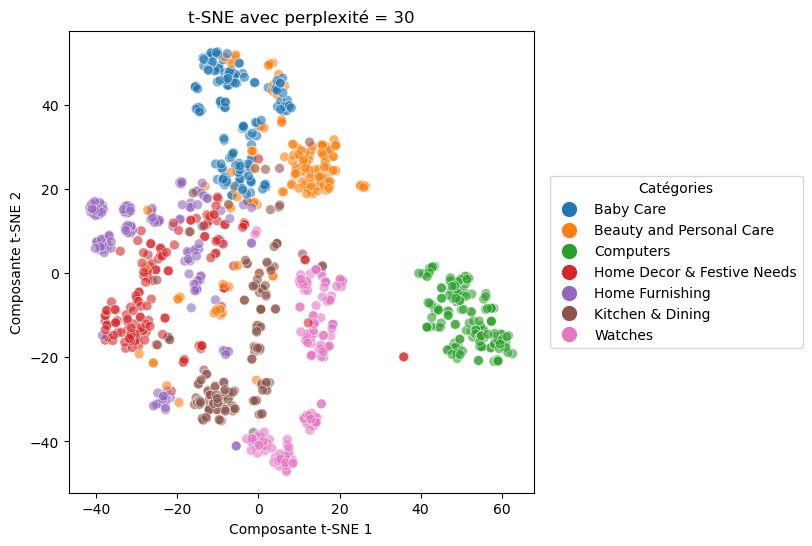

In [107]:
tsne_use = plot_tsne(doc_embeddings_USE, categories_encoded, category_names, 30)

#### Sur LDA

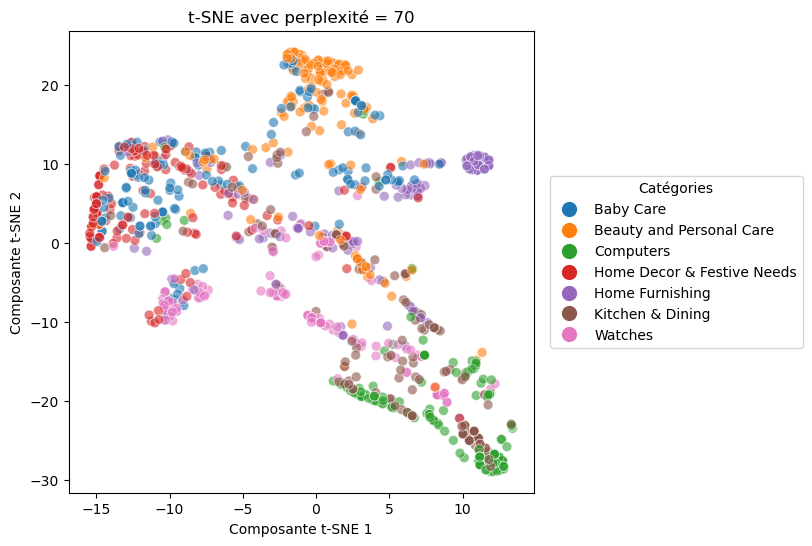

In [108]:
tsne_lda = plot_tsne(topic_matrix, categories_encoded, category_names, 70)

#### Sur NMF

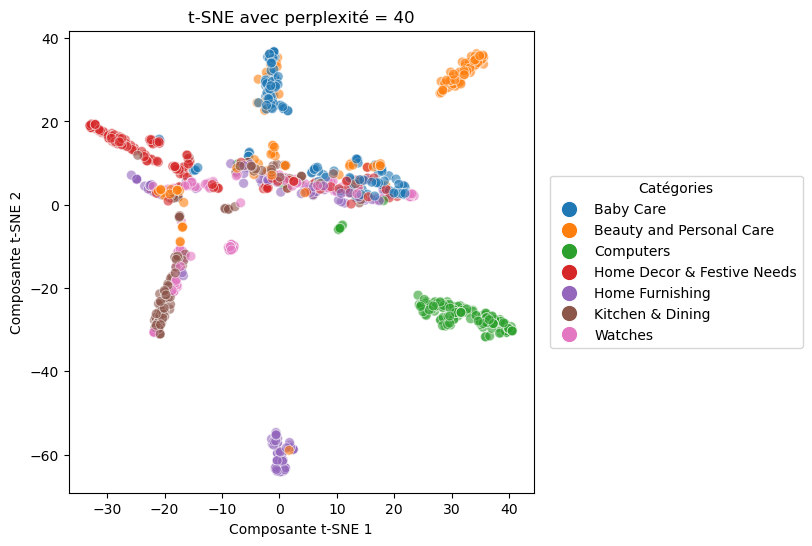

In [109]:
tsne_nmf = plot_tsne(nmf_matrix, categories_encoded, category_names, 40)

### ACP + T-SNE

#### Sur BoW

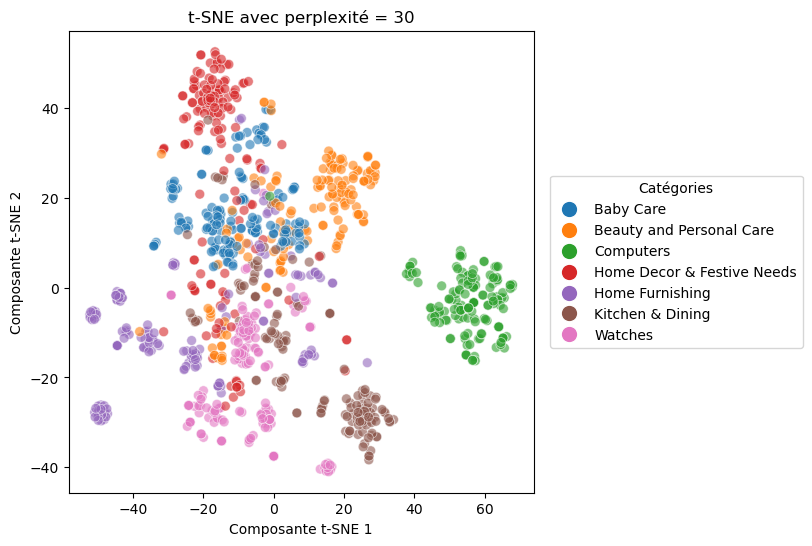

In [110]:
acp_tsne_bow = plot_tsne(reduced_bow, categories_encoded, category_names, 30)

#### Sur Tf-idf

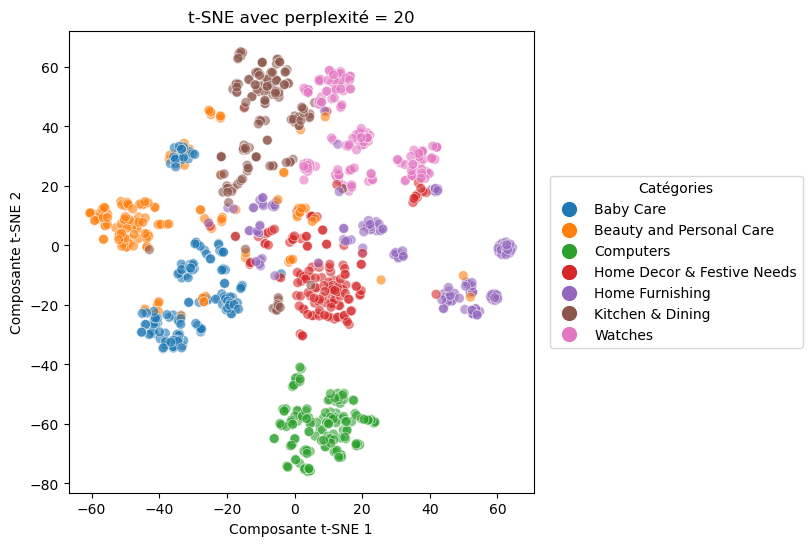

In [111]:
acp_tsne_tfidf = plot_tsne(reduced_tfidf, categories_encoded, category_names, 20)

#### Sur Word2vec

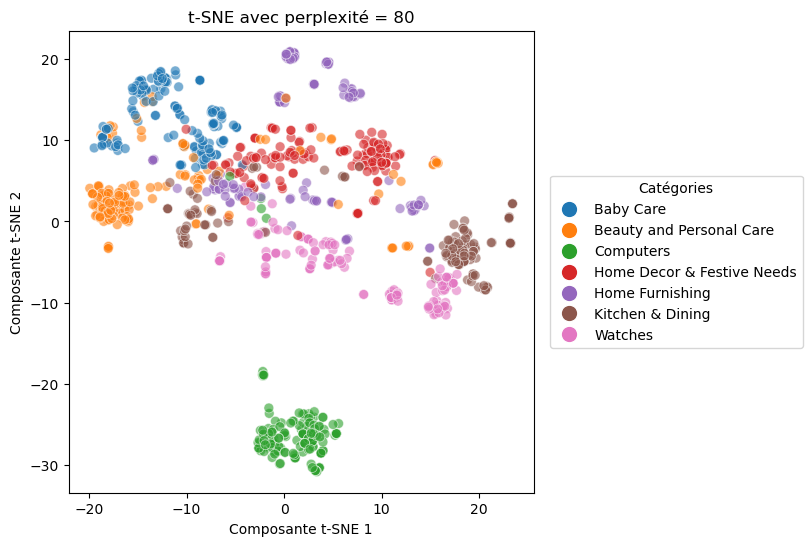

In [112]:
acp_tsne_w2v = plot_tsne(reduced_w2v, categories_encoded, category_names, 80)

#### Sur BERT

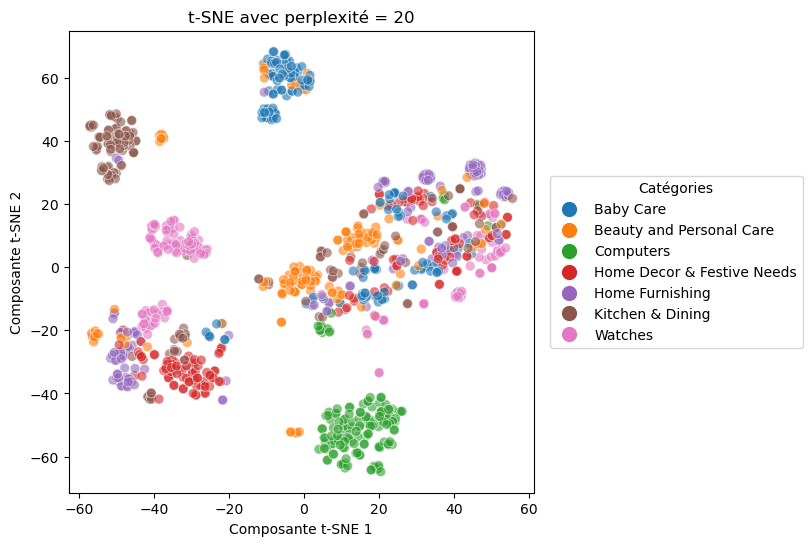

In [113]:
acp_tsne_bert = plot_tsne(reduced_bert, categories_encoded, category_names, 20)

#### Sur USE

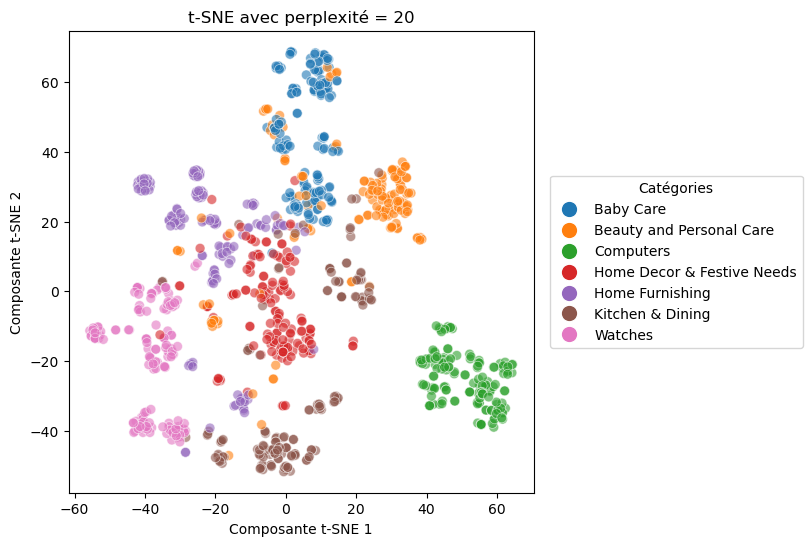

In [114]:
acp_tsne_use = plot_tsne(reduced_use, categories_encoded, category_names, 20)

# K-means

In [115]:
# Nombre de clusters
n_clusters = 7

# Vraie catégories pour comparaison
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(df['product_category'])
category_names = label_encoder.classes_

## sur BoW

Silhouette Score: 0.5053
Adjusted Rand Score: 0.4225
Accuracy: 0.6800


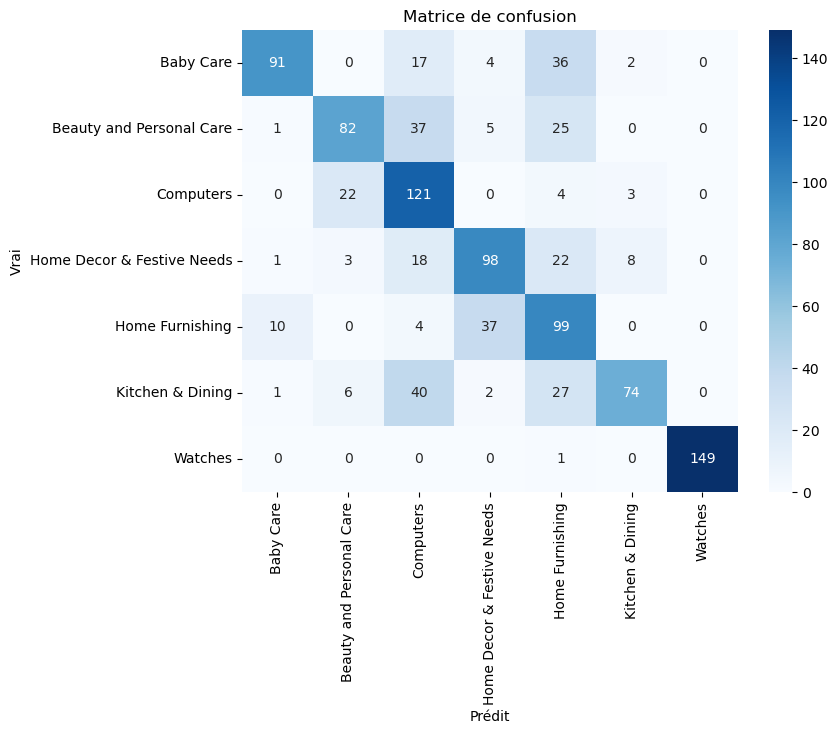

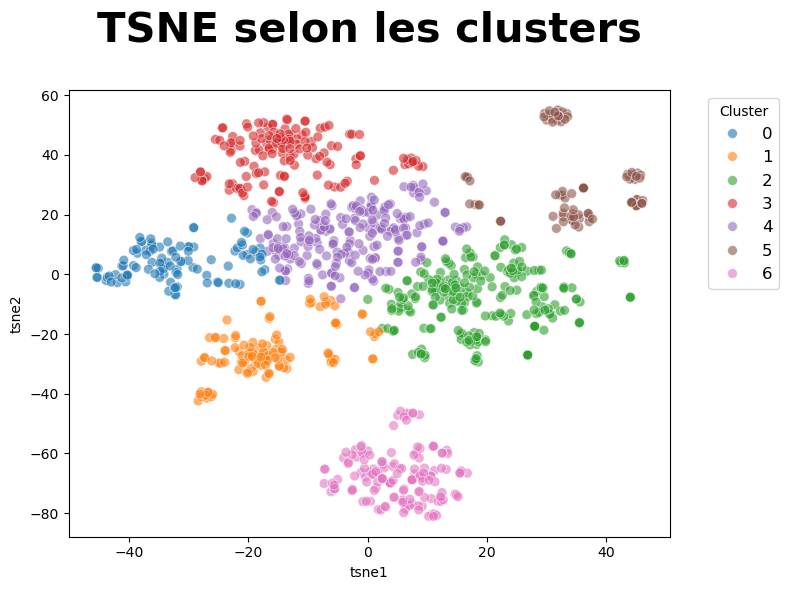

In [116]:
kmeans_metrics_tsne_bow = perform_kmeans(X_data=tsne_bow, true_labels=true_labels_encoded, label_names=category_names,
                                         n_clusters=n_clusters, random_state=42)

Silhouette Score: 0.4965
Adjusted Rand Score: 0.4524
Accuracy: 0.7048


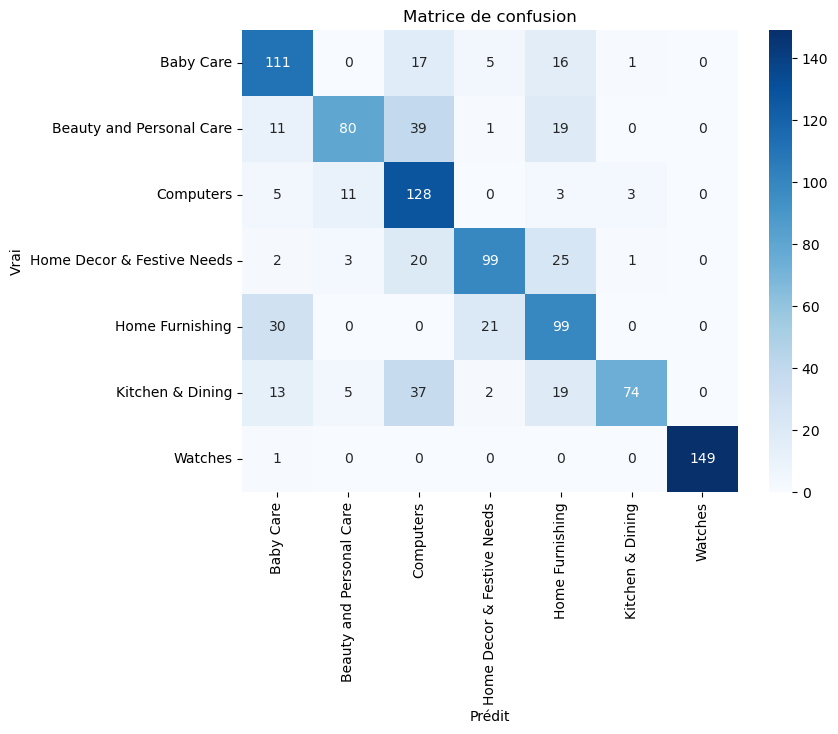

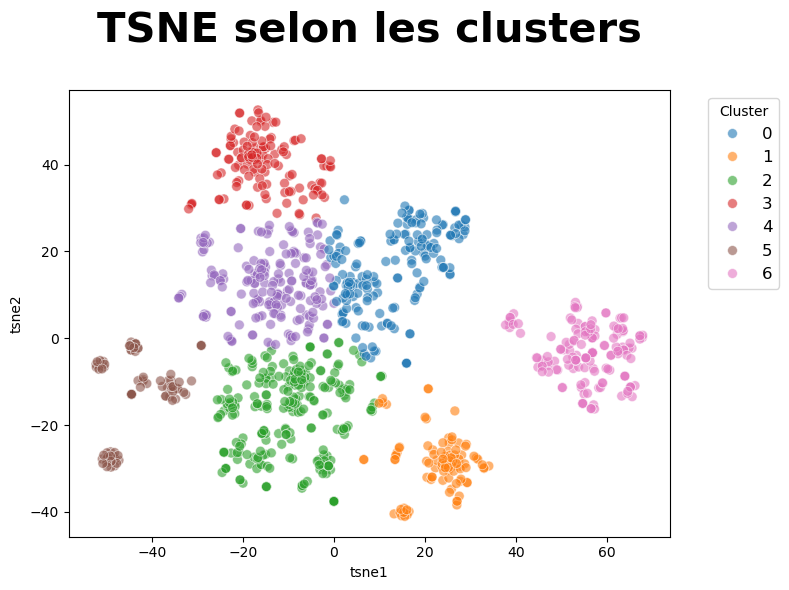

In [117]:
kmeans_metrics_acp_tsne_bow = perform_kmeans(X_data=acp_tsne_bow, true_labels=true_labels_encoded, label_names=category_names,
                                             n_clusters=n_clusters, random_state=42)

## Sur Tf-idf

Silhouette Score: 0.5103
Adjusted Rand Score: 0.5741
Accuracy: 0.7695


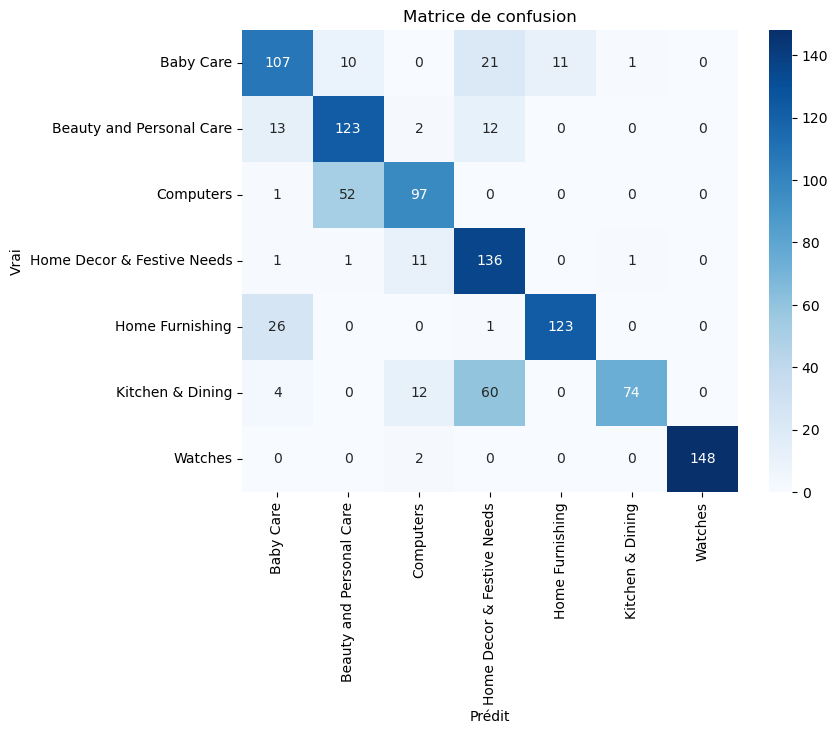

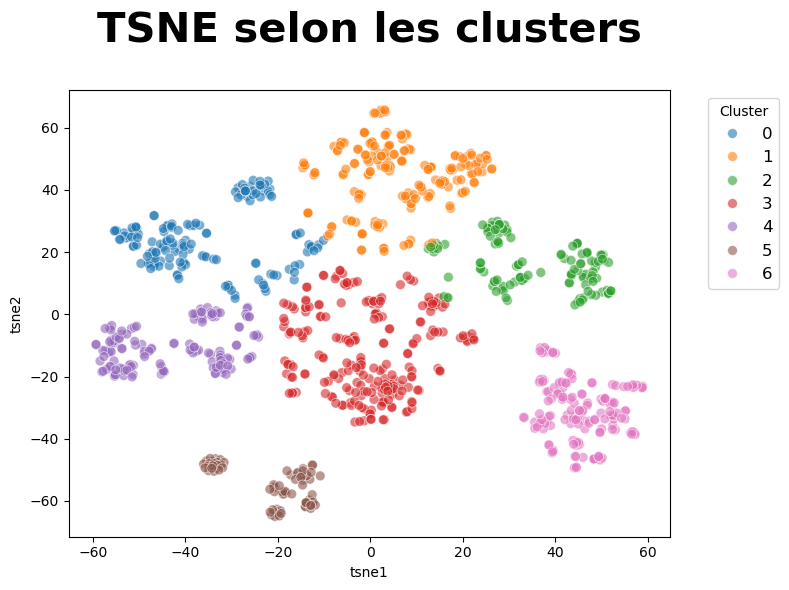

In [118]:
kmeans_metrics_tsne_tfidf = perform_kmeans(X_data=tsne_tfidf, true_labels=true_labels_encoded, label_names=category_names,
                                           n_clusters=n_clusters, random_state=42)

Silhouette Score: 0.5104
Adjusted Rand Score: 0.5847
Accuracy: 0.7771


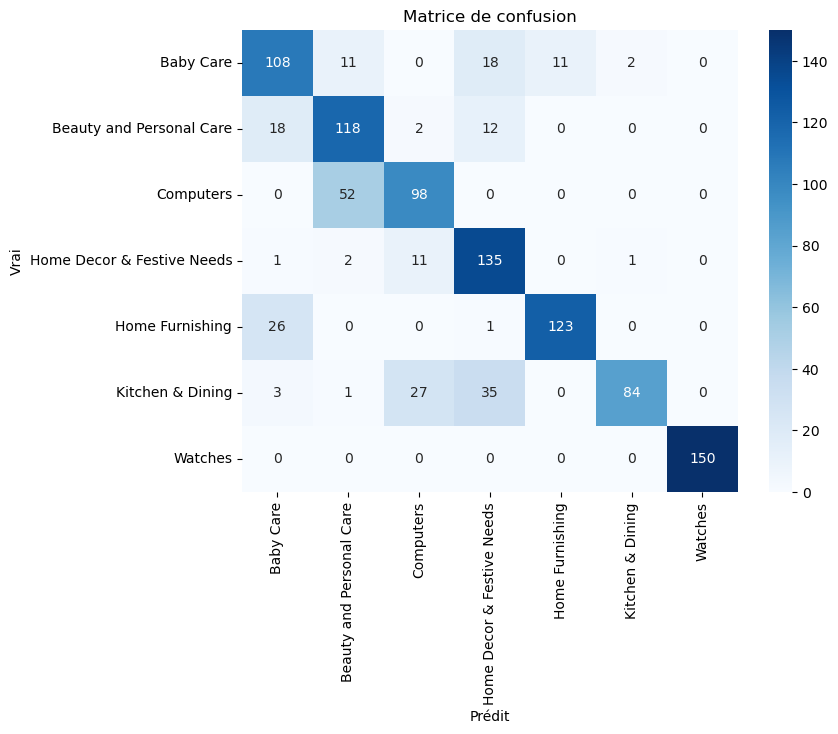

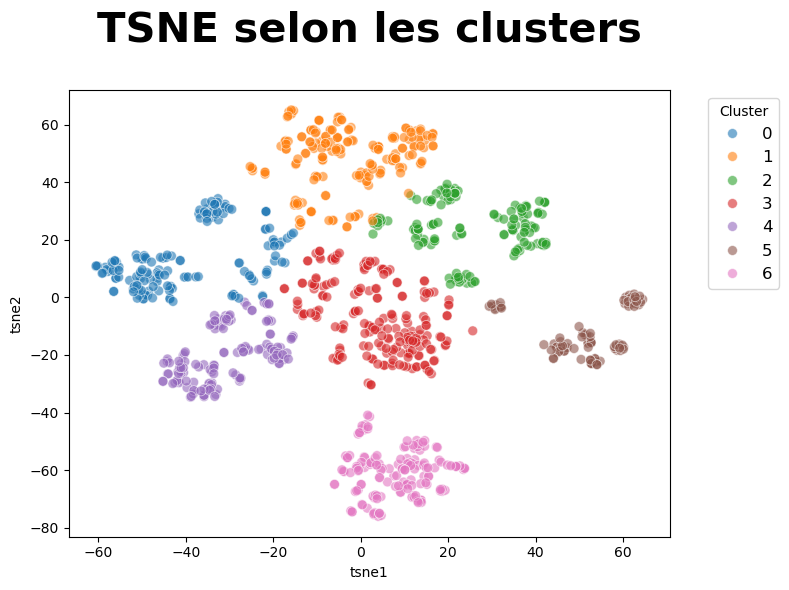

In [119]:
kmeans_metrics_acp_tsne_tfidf = perform_kmeans(X_data=acp_tsne_tfidf, true_labels=true_labels_encoded, label_names=category_names,
                                               n_clusters=n_clusters, random_state=42)

## Sur Word2vec

Silhouette Score: 0.5121
Adjusted Rand Score: 0.4831
Accuracy: 0.6800


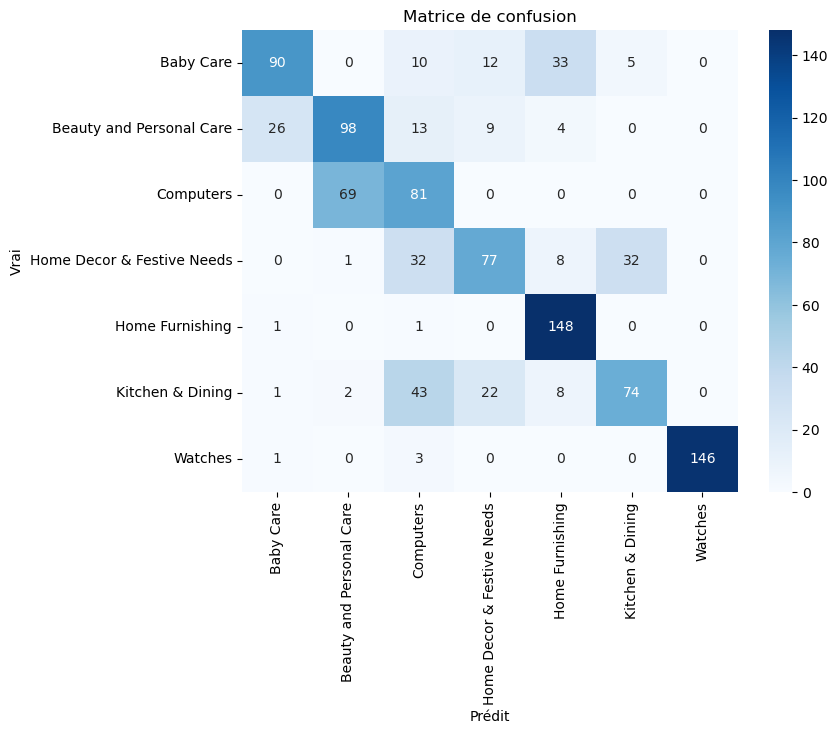

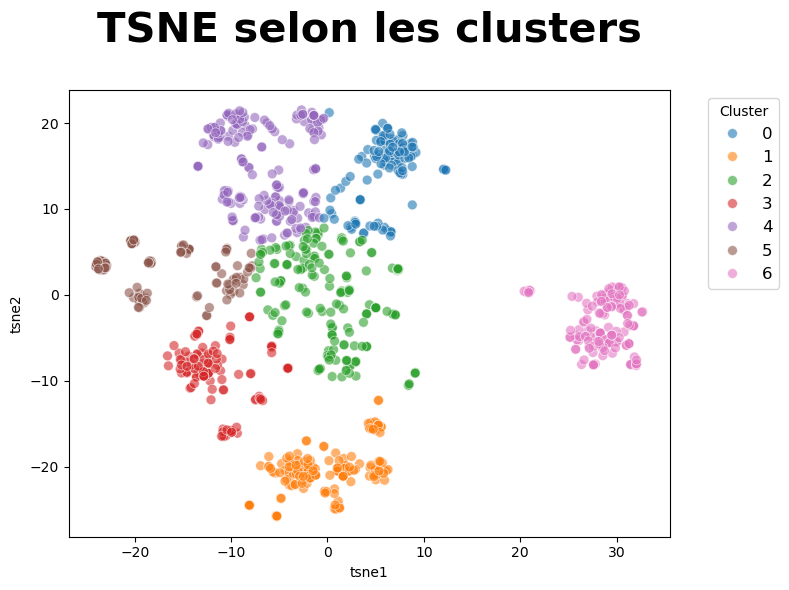

In [120]:
kmeans_metrics_tsne_w2v = perform_kmeans(X_data=tsne_w2v, true_labels=true_labels_encoded, label_names=category_names,
                                         n_clusters=n_clusters, random_state=42)

Silhouette Score: 0.5044
Adjusted Rand Score: 0.5008
Accuracy: 0.6924


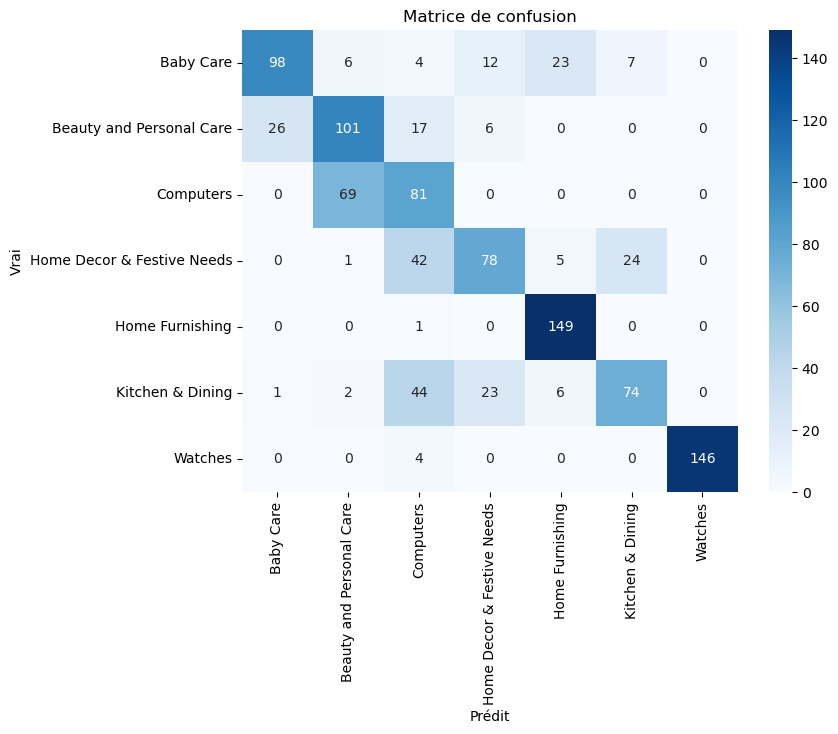

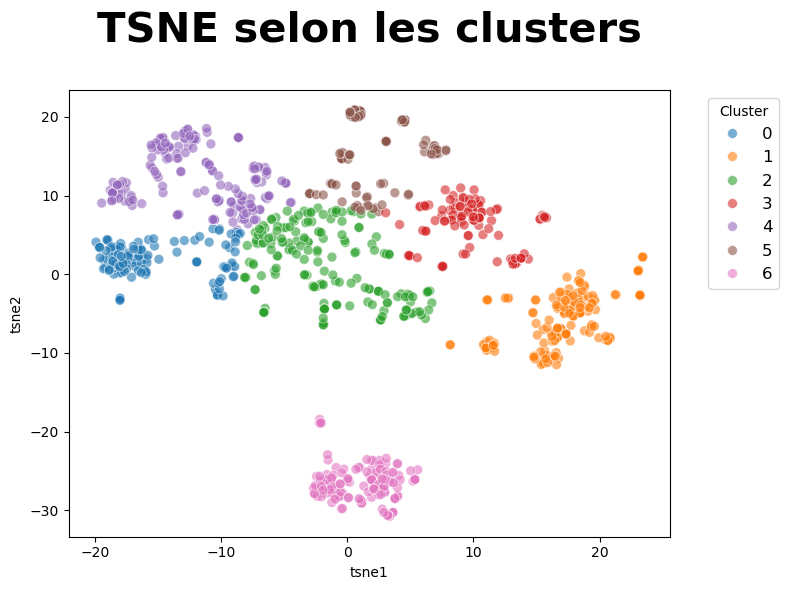

In [121]:
kmeans_metrics_acp_tsne_w2v = perform_kmeans(X_data=acp_tsne_w2v, true_labels=true_labels_encoded, label_names=category_names,
                                             n_clusters=n_clusters, random_state=42)

## Sur BERT

Silhouette Score: 0.5982
Adjusted Rand Score: 0.2960
Accuracy: 0.5829


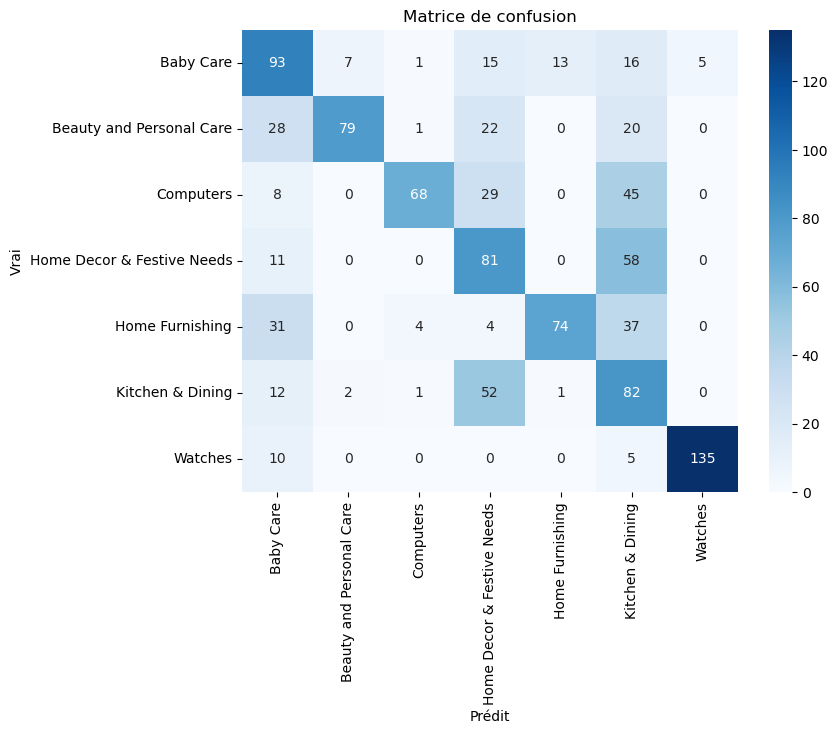

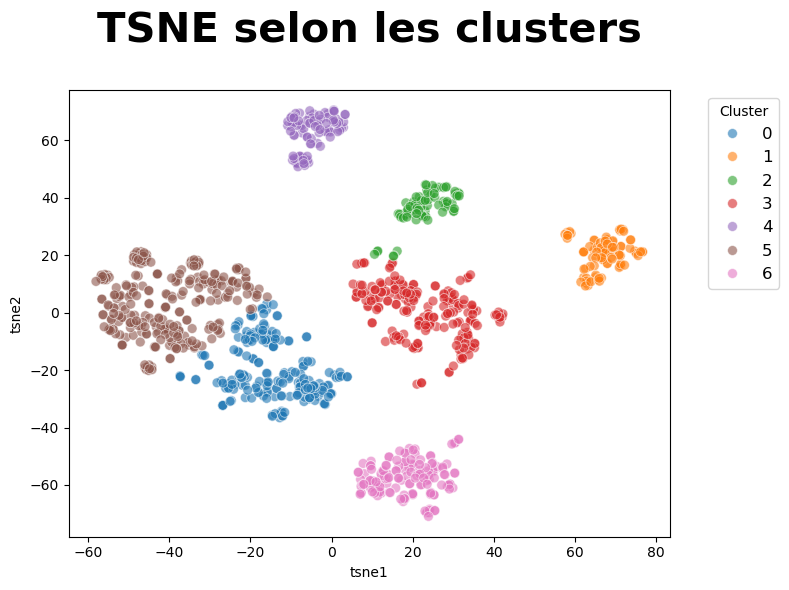

In [122]:
kmeans_metrics_tsne_bert = perform_kmeans(X_data=tsne_bert, true_labels=true_labels_encoded, label_names=category_names,
                                          n_clusters=n_clusters, random_state=42)

Silhouette Score: 0.6029
Adjusted Rand Score: 0.2876
Accuracy: 0.5781


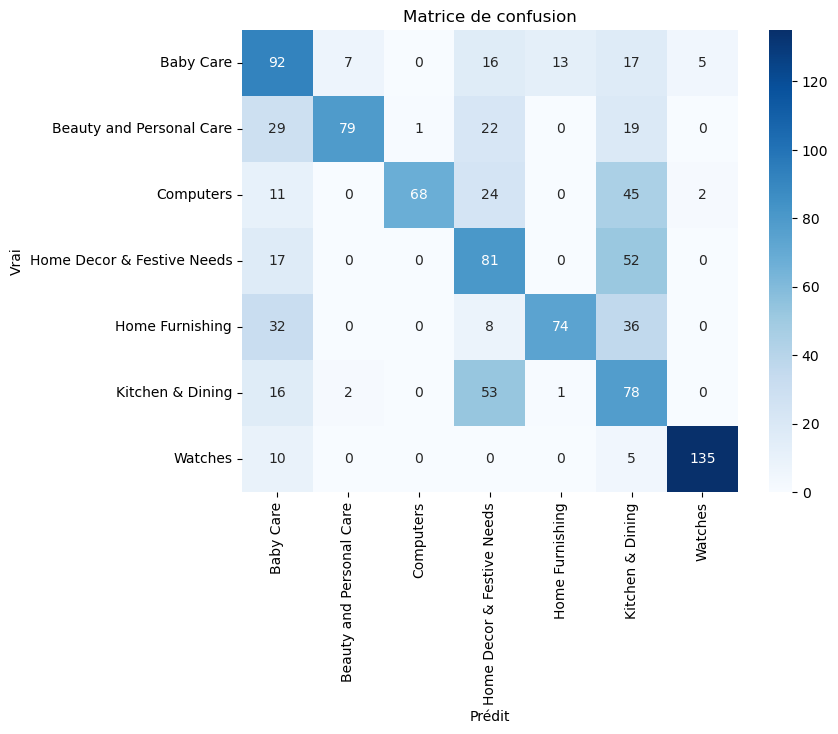

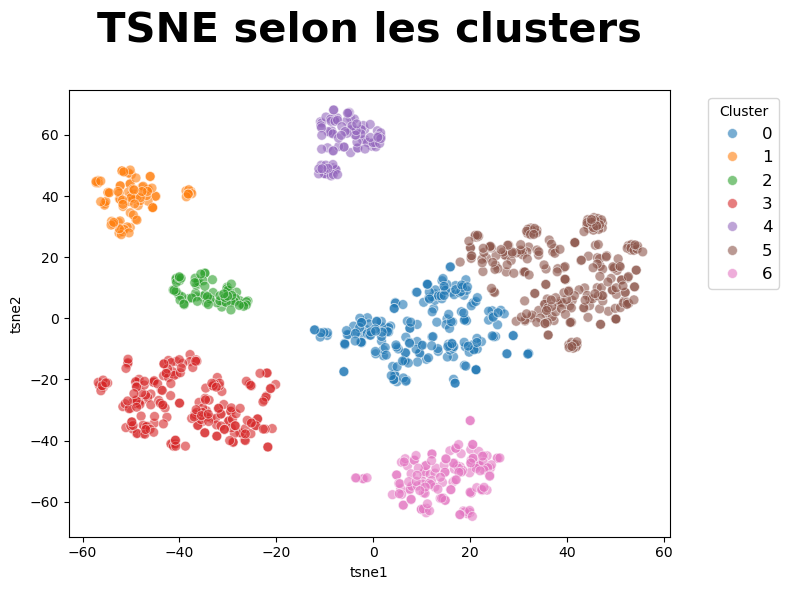

In [123]:
kmeans_metrics_acp_tsne_bert = perform_kmeans(X_data=acp_tsne_bert, true_labels=true_labels_encoded, label_names=category_names,
                                              n_clusters=n_clusters, random_state=42)

## Sur USE

Silhouette Score: 0.4935
Adjusted Rand Score: 0.4871
Accuracy: 0.6743


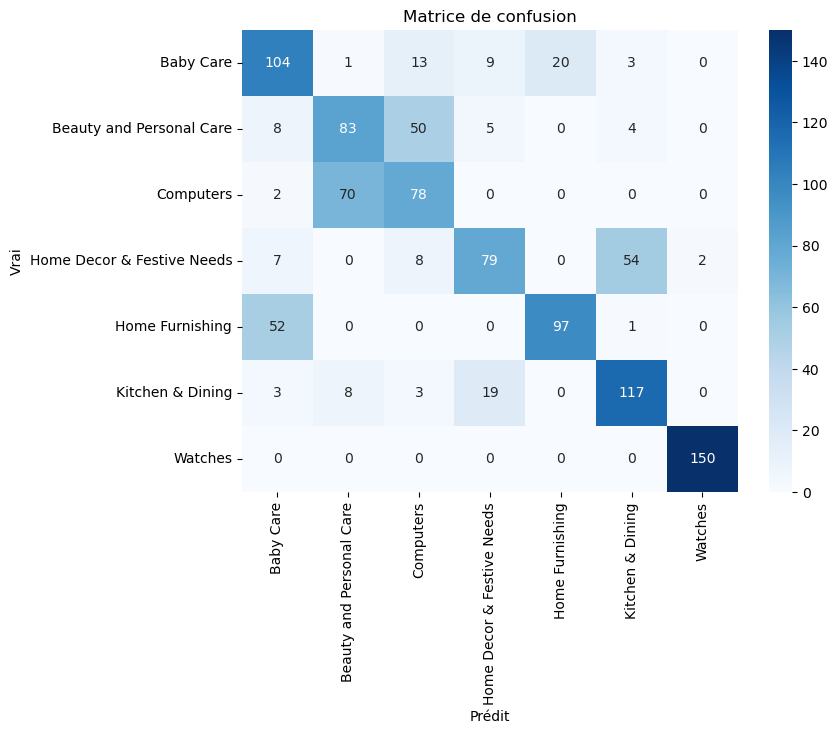

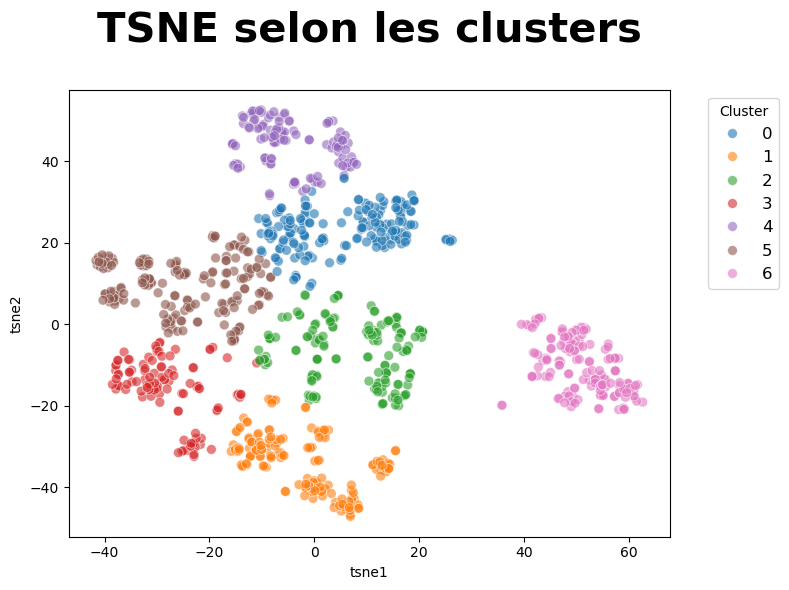

In [124]:
kmeans_metrics_tsne_use = perform_kmeans(X_data=tsne_use, true_labels=true_labels_encoded, label_names=category_names,
                                         n_clusters=n_clusters, random_state=42)

Silhouette Score: 0.4945
Adjusted Rand Score: 0.5723
Accuracy: 0.7638


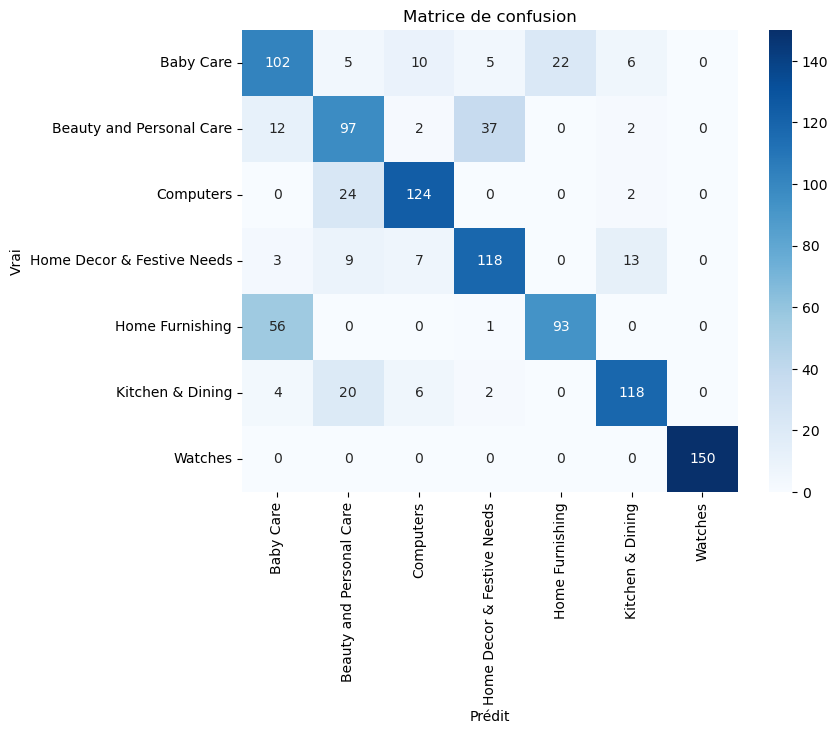

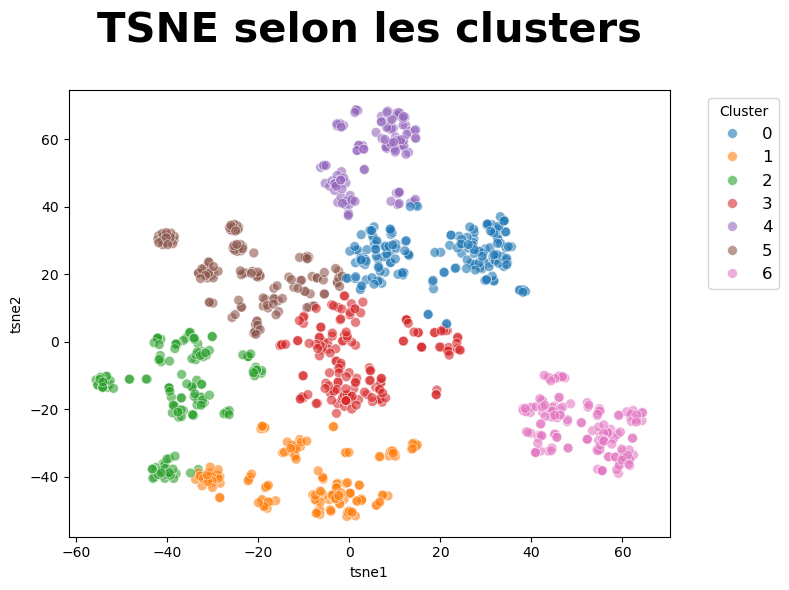

In [125]:
kmeans_metrics_acp_tsne_use = perform_kmeans(X_data=acp_tsne_use, true_labels=true_labels_encoded, label_names=category_names,
                                             n_clusters=n_clusters, random_state=42)

## Sur LDA

Silhouette Score: 0.5166
Adjusted Rand Score: 0.2906
Accuracy: 0.4857


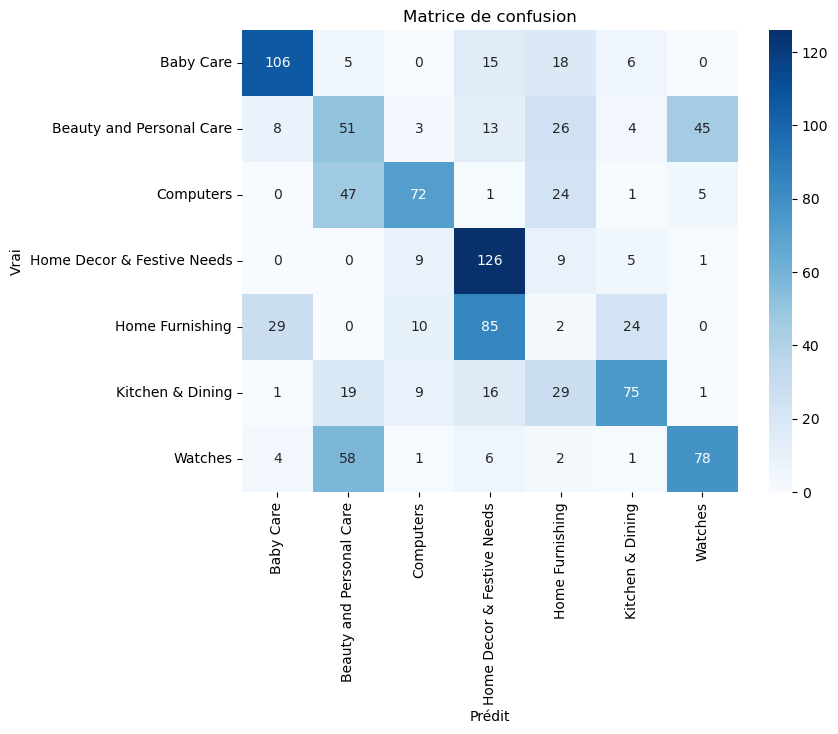

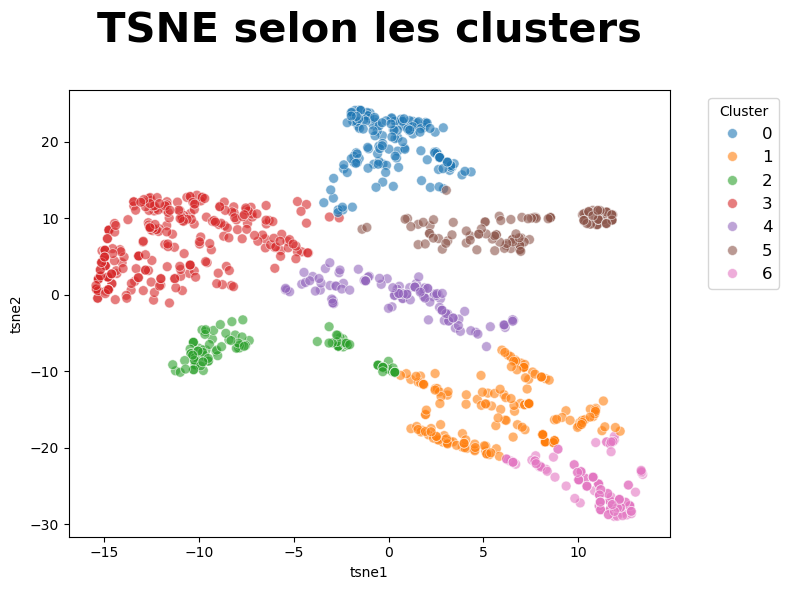

In [126]:
kmeans_metrics_tsne_lda = perform_kmeans(X_data=tsne_lda, true_labels=true_labels_encoded, label_names=category_names,
                                         n_clusters=n_clusters, random_state=42)

## Sur NMF

Silhouette Score: 0.6728
Adjusted Rand Score: 0.3350
Accuracy: 0.5943


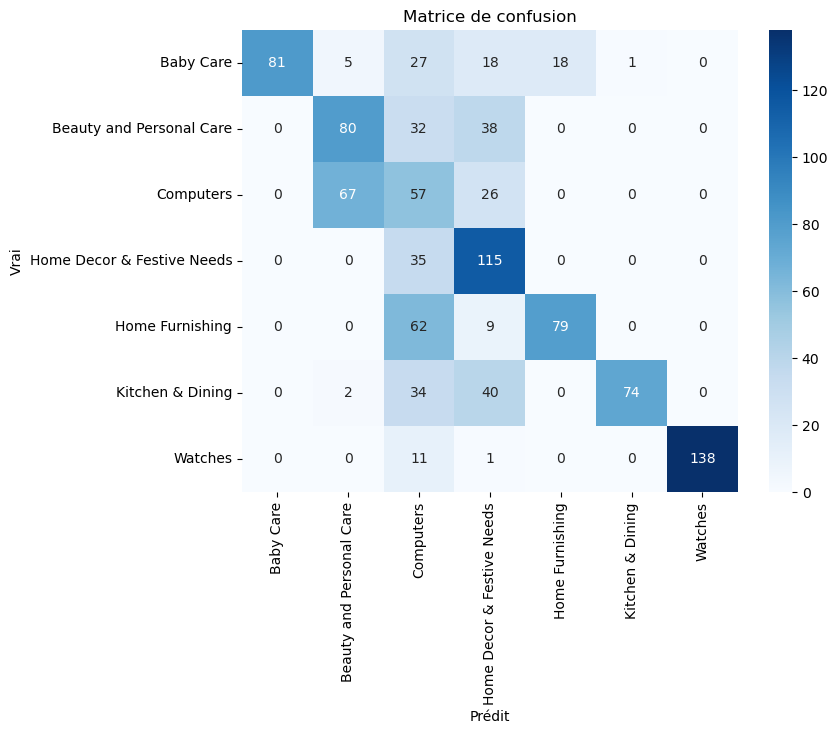

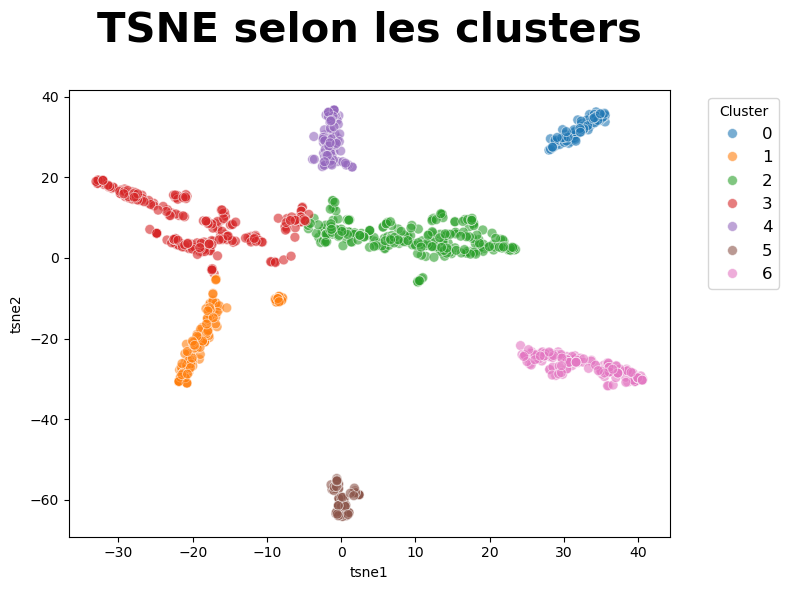

In [127]:
kmeans_metrics_tsne_nmf = perform_kmeans(X_data=tsne_nmf, true_labels=true_labels_encoded, label_names=category_names,
                                         n_clusters=n_clusters, random_state=42)

## Comparaison des résultats

In [128]:
# Dictionnaire de toutes les métriques obtenues
all_metrics = {
    'TSNE BoW': kmeans_metrics_tsne_bow,
    'ACP TSNE BoW': kmeans_metrics_acp_tsne_bow,
    'TSNE TF-IDF': kmeans_metrics_tsne_tfidf,
    'ACP TSNE TF-IDF': kmeans_metrics_acp_tsne_tfidf,
    'TSNE Word2Vec': kmeans_metrics_tsne_w2v,
    'ACP TSNE Word2Vec': kmeans_metrics_acp_tsne_w2v,
    'TSNE BERT': kmeans_metrics_tsne_bert,
    'ACP TSNE BERT': kmeans_metrics_acp_tsne_bert,
    'TSNE USE': kmeans_metrics_tsne_use,
    'ACP TSNE USE': kmeans_metrics_acp_tsne_use,
    'TSNE LDA': kmeans_metrics_tsne_lda,
    'TSNE NMF': kmeans_metrics_tsne_nmf
}

In [130]:
# Convertir le dictionnaire de métriques en DataFrame pour la visualisation
data = []
for method, metrics in all_metrics.items():
    for metric_name, value in metrics.items():
        data.append({'Method': method, 'Metric': metric_name, 'Score': value})

data_metrics = pd.DataFrame(data)

# Vérification de la structure du DataFrame
print(data_metrics.head())

         Method               Metric     Score
0      TSNE BoW     Silhouette Score  0.505297
1      TSNE BoW  Adjusted Rand Score  0.422531
2      TSNE BoW             Accuracy  0.680000
3  ACP TSNE BoW     Silhouette Score  0.496493
4  ACP TSNE BoW  Adjusted Rand Score  0.452361


In [131]:
# Trier le DataFrame par Adjusted Rand Score dans chaque groupe
df_adjusted = data_metrics[data_metrics['Metric'] == 'Adjusted Rand Score'].sort_values(by='Score', ascending=False)
sorted_methods = df_adjusted['Method'].values

# Fusionner les données triées avec le DataFrame original pour respecter cet ordre
data_metrics['Method'] = pd.Categorical(data_metrics['Method'], categories=sorted_methods, ordered=True)
data_metrics = data_metrics.sort_values('Method')

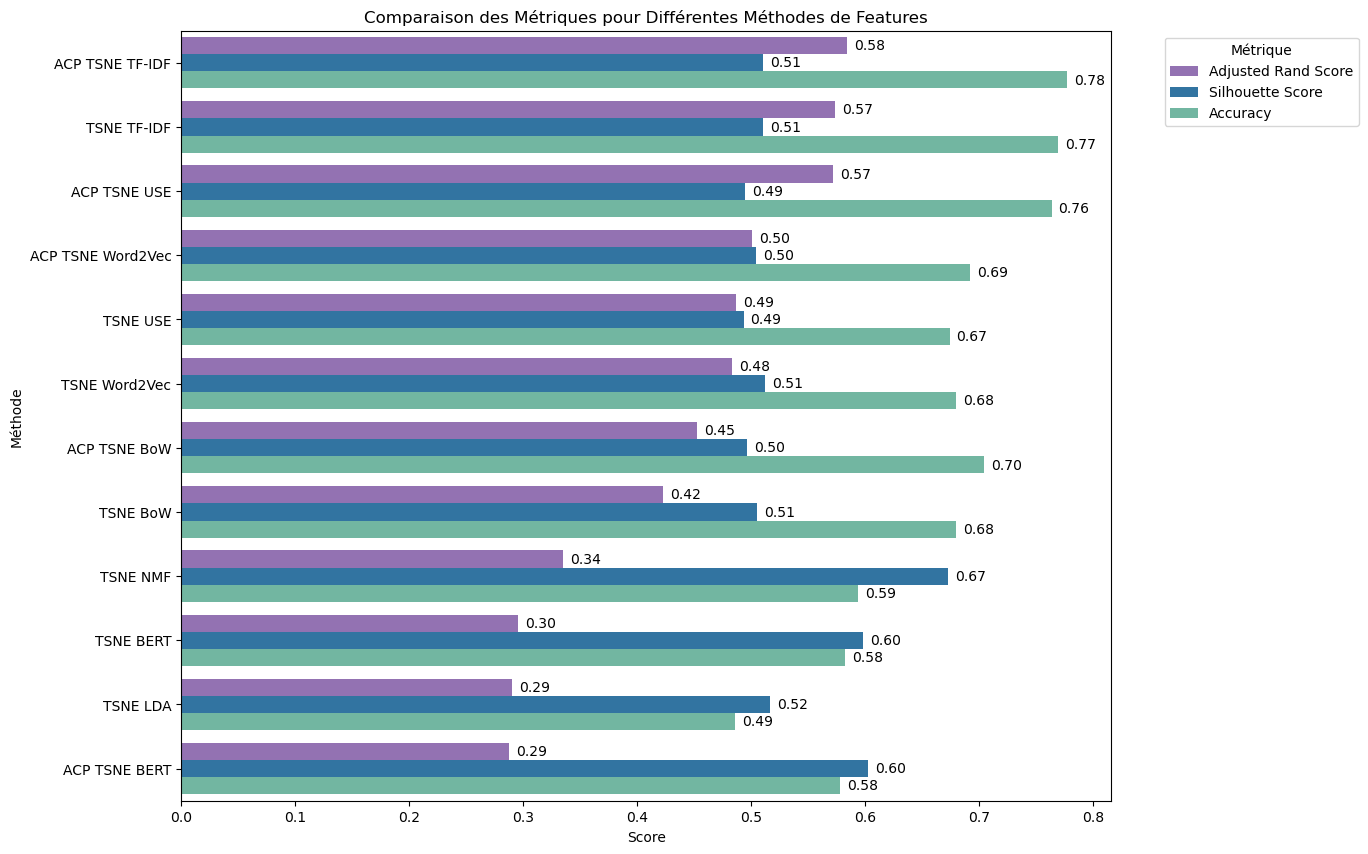

In [132]:
# Définition des couleurs spécifiques pour chaque métrique
palette = {'Silhouette Score': '#1f77b4',  # Bleu
           'Adjusted Rand Score': '#9467bd',  # Pourpre
           'Accuracy': '#66c2a5'}  # Vert pastel

# Création du graphique en barres
plt.figure(figsize=(12, 10))
barplot = sns.barplot(data=data_metrics, y='Method', x='Score', hue='Metric', palette=palette)

# Ajouter des valeurs de score sur les barres
for p in barplot.patches:
    width = p.get_width()
    if width != 0: 
        plt.annotate(f'{width:.2f}', 
                     xy=(width, p.get_y() + p.get_height() / 2),
                     xytext=(5, 0), 
                     textcoords='offset points', 
                     ha='left', 
                     va='center')

# Ajout de titres et labels
plt.title('Comparaison des Métriques pour Différentes Méthodes de Features')
plt.xlabel('Score')
plt.ylabel('Méthode')

plt.legend(title='Métrique', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

#### Sélections

In [142]:
# Dictionnaire de toutes les métriques obtenues
select_metrics = {
    'BoW': kmeans_metrics_acp_tsne_bow,
    'TF-IDF': kmeans_metrics_acp_tsne_tfidf,
    'Word2Vec': kmeans_metrics_acp_tsne_w2v,
    'BERT': kmeans_metrics_acp_tsne_bert,
    'USE': kmeans_metrics_acp_tsne_use,
    'LDA': kmeans_metrics_tsne_lda,
    'NMF': kmeans_metrics_tsne_nmf
}

In [143]:
# Convertir le dictionnaire de métriques en DataFrame pour la visualisation
select_data = []
for method, metrics in select_metrics.items():
    for metric_name, value in metrics.items():
        select_data.append({'Method': method, 'Metric': metric_name, 'Score': value})

select_data_metrics = pd.DataFrame(select_data)

# Vérification de la structure du DataFrame
print(select_data_metrics.head())

   Method               Metric     Score
0     BoW     Silhouette Score  0.496493
1     BoW  Adjusted Rand Score  0.452361
2     BoW             Accuracy  0.704762
3  TF-IDF     Silhouette Score  0.510373
4  TF-IDF  Adjusted Rand Score  0.584650


In [144]:
# Trier le DataFrame par Adjusted Rand Score dans chaque groupe
df_adjusted = select_data_metrics[select_data_metrics['Metric'] == 'Adjusted Rand Score'].sort_values(by='Score', ascending=False)
sorted_methods = df_adjusted['Method'].values

# Fusionner les données triées avec le DataFrame original pour respecter cet ordre
select_data_metrics['Method'] = pd.Categorical(select_data_metrics['Method'], categories=sorted_methods, ordered=True)
select_data_metrics = select_data_metrics.sort_values('Method')

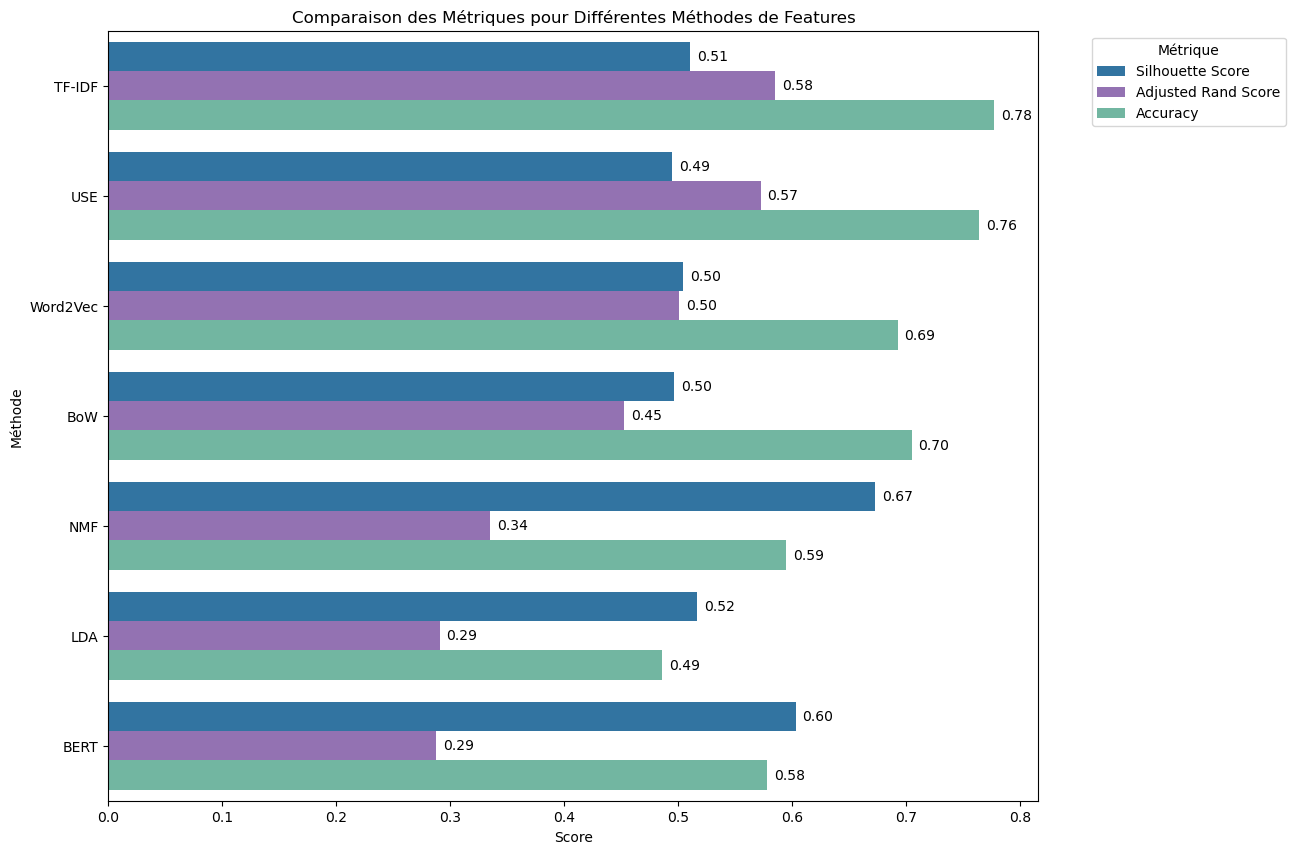

In [145]:
# Définition des couleurs spécifiques pour chaque métrique
palette = {'Silhouette Score': '#1f77b4',  # Bleu
           'Adjusted Rand Score': '#9467bd',  # Pourpre
           'Accuracy': '#66c2a5'}  # Vert pastel

# Création du graphique en barres
plt.figure(figsize=(12, 10))
barplot = sns.barplot(data=select_data_metrics, y='Method', x='Score', hue='Metric', palette=palette)

# Ajouter des valeurs de score sur les barres
for p in barplot.patches:
    width = p.get_width()
    if width != 0: 
        plt.annotate(f'{width:.2f}', 
                     xy=(width, p.get_y() + p.get_height() / 2),
                     xytext=(5, 0), 
                     textcoords='offset points', 
                     ha='left', 
                     va='center')

# Ajout de titres et labels
plt.title('Comparaison des Métriques pour Différentes Méthodes de Features')
plt.xlabel('Score')
plt.ylabel('Méthode')

plt.legend(title='Métrique', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()